In [2]:
import rasterio
import rasterio.windows
import rasterio.features 
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points 
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from scipy.spatial.distance import cdist # For calculating distances between points
import networkx as nx 

# --- Configuration ---
# Base directory for all your GIS data files
GIS_BASE_DIR = "/Users/rakibhhridoy/Five_Rivers/gis" # <--- IMPORTANT: Update this path to your GIS data directory

# Subdirectories for LULC and CalIndices TIFF files
LULC_DIR = os.path.join(GIS_BASE_DIR, "LULCMerged")
CAL_INDICES_DIR = os.path.join(GIS_BASE_DIR, "CalIndices")

# Paths to your point shapefiles
SAMPLING_POINTS_PATH = os.path.join(GIS_BASE_DIR, "sampling_point.shp")
BRICK_FIELD_POINTS_PATH = os.path.join(GIS_BASE_DIR, "brick_field_point.shp")
INDUSTRY_POINTS_PATH = os.path.join(GIS_BASE_DIR, "industry_point.shp")

# Output CSV file paths for intermediate and final processed data
OUTPUT_LULC_VARIATIONS_CSV = os.path.join(GIS_BASE_DIR, "LULC_5km_Variations.csv")
OUTPUT_HYDRO_PROPERTIES_CSV = os.path.join(GIS_BASE_DIR, "Hydrological_Properties.csv")
OUTPUT_RASTER_FEATURES_CSV = os.path.join(GIS_BASE_DIR, "Raster_Derived_Features.csv")
OUTPUT_COMBINED_FEATURES_CSV = os.path.join(GIS_BASE_DIR, "Combined_Features_Scaled.csv")

In [3]:
LULC_YEARS = list(range(2017, 2023)) # Covers 2017, 2018, 2019, 2020, 2021, 2022
UNIFORM_BUFFER_RADIUS_METERS = 5000 # 5 km

# CNN Patch Size (pixels) - for extracting image patches around points for CNN branch
# This is a pixel dimension, not a real-world radius.
CNN_PATCH_SIZE = 32 # e.g., 32x32 pixels

# GNN Edge Definition: Distance threshold for connecting nodes (sampling stations)
# This creates a proximity graph as an approximation of hydrological connectivity.
GNN_EDGE_DISTANCE_THRESHOLD_METERS = 5000 # 5 km for connecting stations

# List of raster indices to extract neighborhood statistics from
RASTER_INDICES_TO_EXTRACT = [
    "awei.tif", "bui.tif", "evi.tif", "mndwi.tif", "ndbi.tif",
    "ndbsi.tif", "ndsi.tif", "ndvi.tif", "ndwi.tif", "savi.tif", "ui.tif"
]
# Path to DEM file
DEM_PATH = os.path.join(GIS_BASE_DIR, "DEMF.tif")

In [4]:
# --- Helper Functions ---
# These functions are designed to encapsulate common geospatial operations,
# making the main pipeline cleaner and more modular.

def load_raster(filepath, reference_crs):
    """
    Loads a single raster file. If its CRS does not match the reference_crs,
    it reprojects the raster to the reference_crs.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Raster file not found: {filepath}")
    
    with rasterio.open(filepath) as src:
        if src.crs != reference_crs:
            print(f"Reprojecting {os.path.basename(filepath)} from {src.crs} to {reference_crs}...")
            from rasterio.warp import reproject, Resampling
            
            # Calculate new transform and dimensions for reprojection
            transform, width, height = rasterio.windows.calculate_default_transform(
                src.crs, reference_crs, src.width, src.height, *src.bounds
            )
            reprojected_array = np.empty((height, width), dtype=src.dtypes)
            reproject(
                source=rasterio.band(src, 1),
                destination=reprojected_array,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=reference_crs,
                resampling=Resampling.nearest # Use nearest for categorical LULC, bilinear for continuous DEM/indices
            )
            profile = src.profile.copy()
            profile.update({
                'crs': reference_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            return reprojected_array, profile
        else:
            return src.read(1), src.profile

def extract_neighborhood_stats(raster_array, raster_profile, point_geom, buffer_meters, stat_type='mean'):
    """
    Extracts neighborhood statistics (mean, stddev) from a raster for a given point buffer.
    This function crops the raster to the buffer's bounding box and then masks it with the circular buffer.
    """
    buffer_geom = point_geom.buffer(buffer_meters)
    
    # Get the window (bounding box in pixel coordinates) for the buffer
    window = rasterio.windows.from_bounds(*buffer_geom.bounds, transform=raster_profile['transform'])
    
    # Clamp window to raster dimensions to prevent out-of-bounds access
    row_start, row_stop = int(window.row_off), int(window.row_off + window.height)
    col_start, col_stop = int(window.col_off), int(window.col_off + window.width)
    
    row_start = max(0, row_start)
    row_stop = min(raster_array.shape[0], row_stop)
    col_start = max(0, col_start)
    col_stop = min(raster_array.shape[1], col_stop)

    if row_stop <= row_start or col_stop <= col_start:
        return np.nan # No valid overlap
    
    # Extract the subset of the raster array (rectangular crop)
    cropped_array = raster_array[row_start:row_stop, col_start:col_stop]
    # Create a new transform for this cropped array's extent
    cropped_transform = rasterio.windows.transform(window, raster_profile['transform'])

    # Rasterize the buffer geometry onto a new array of the same shape as cropped_array
    pixel_mask_for_buffer = rasterio.features.rasterize(
        [buffer_geom],
        out_shape=cropped_array.shape,
        transform=cropped_transform,
        fill=0,
        all_touched=False, # Only pixels strictly inside
        dtype=np.uint8
    ).astype(bool) # Convert to boolean mask (True for inside, False for outside)

    # Apply the pixel mask to the cropped array to get pixels within the circular buffer
    pixels_within_buffer = cropped_array[pixel_mask_for_buffer]
    
    if pixels_within_buffer.size > 0:
        if stat_type == 'mean':
            return np.mean(pixels_within_buffer)
        elif stat_type == 'std':
            return np.std(pixels_within_buffer)
        else:
            raise ValueError("Unsupported stat_type. Use 'mean' or 'std'.")
    else:
        return np.nan # No valid pixels in buffer

def extract_raster_patch(raster_array, raster_profile, point_geom, patch_size):
    """
    Extracts a square image patch around a point for CNN input.
    Handles boundary conditions by padding the raster.
    """
    # Convert point_geom to pixel coordinates
    col, row = raster_profile['transform'](point_geom.x, point_geom.y, op=~raster_profile['transform'])
    col, row = int(col), int(row)

    half_patch = patch_size // 2

    # Create a padded array to handle points near edges gracefully
    padded_array = np.pad(raster_array, half_patch, mode='reflect') 
    
    # Adjust coordinates for the padded array
    padded_row_start = row + half_patch - half_patch
    padded_row_end = row + half_patch + half_patch
    padded_col_start = col + half_patch - half_patch
    padded_col_end = col + half_patch + half_patch

    # Extract patch from padded array
    patch = padded_array[padded_row_start:padded_row_end, padded_col_start:padded_col_end]
    
    # Ensure the patch is exactly patch_size x patch_size
    if patch.shape != (patch_size, patch_size):
        print(f"Warning: Patch for point at ({point_geom.x}, {point_geom.y}) is not {patch_size}x{patch_size}. Returning NaN array.")
        return np.full((patch_size, patch_size), np.nan) # Return NaN array if extraction fails
    
    return patch

In [6]:
rainy_df = pd.read_csv("data/Hydro_LULC_Winter.csv")
rainy_df.head()

,Stations,River,Lat,Long,geometry,hydrological_dist_to_nearest_BF,num_upstream_BF,hydrological_dist_to_nearest_IND,num_upstream_IND,CrW,...,MW,SandW,SiltW,ClayW,FeW,variation_17_18,variation_18_19,variation_19_20,variation_20_21,variation_21_22
0,S1,Dhaleshwari,23.910260,90.229845,POINT (10044340.399756001 2742476.70627368),0.000200,6,0.006790,2,106.58,...,30.69,16,51,28,29400,14.396884,8.830319,11.964628,10.162627,10.226519
1,S2,Dhaleshwari,23.858227,90.240038,POINT (10045475.079325657 2736141.9436627394),0.000020,1,0.000000,0,104.28,...,32.41,16,62,27,32100,12.920722,9.676226,13.489252,10.422661,11.249439
2,S3,Dhaleshwari,23.802571,90.245390,POINT (10046070.861240383 2729368.914036628),0.000200,6,0.002100,4,89.77,...,30.14,57,30,17,27970,11.966286,10.483110,15.459976,10.687158,11.446218
3,S4,Dhaleshwari,23.754298,90.246581,POINT (10046203.442753918 2723496.704977303),0.073026,2,0.027234,6,71.55,...,29.58,71,18,13,25780,21.385412,15.447605,20.766508,13.685776,13.207538
4,S5,Dhaleshwari,23.702157,90.277077,POINT (10049598.24194515 2717156.4153029486),0.074113,15,0.122163,5,100.15,...,33.78,75,19,9,36480,18.108141,14.249969,17.320514,12.567463,11.587011


In [7]:
rainy_df.columns

Index(['Stations', 'River', 'Lat', 'Long', 'geometry',
       'hydrological_dist_to_nearest_BF', 'num_upstream_BF',
       'hydrological_dist_to_nearest_IND', 'num_upstream_IND', 'CrW', 'NiW',
       'CuW', 'AsW', 'CdW', 'PbW', 'MW', 'SandW', 'SiltW', 'ClayW', 'FeW',
       'variation_17_18', 'variation_18_19', 'variation_19_20',
       'variation_20_21', 'variation_21_22'],
      dtype='object')

In [10]:
hm_col = ['Stations', 'River', 'Lat', 'Long', 'CrW', 'NiW',
       'CuW', 'AsW', 'CdW', 'PbW', 'FeW']

In [11]:
heavy_metal_df = rainy_df[hm_col]
heavy_metal_df.set_index('Stations', inplace=True)
heavy_metal_df.head()

,River,Lat,Long,CrW,NiW,CuW,AsW,CdW,PbW,FeW
Stations,,,,,,,,,,
S1,Dhaleshwari,23.910260,90.229845,106.58,34.35,69.95,9.12,4.43,105.90,29400
S2,Dhaleshwari,23.858227,90.240038,104.28,27.10,75.12,13.79,3.82,96.14,32100
S3,Dhaleshwari,23.802571,90.245390,89.77,59.33,71.13,26.17,2.95,77.36,27970
S4,Dhaleshwari,23.754298,90.246581,71.55,49.17,92.34,25.35,2.36,90.48,25780
S5,Dhaleshwari,23.702157,90.277077,100.15,50.68,100.22,28.37,2.10,79.10,36480


In [12]:
print("\n--- Step 1.2: Loading LULC Rasters and establishing Reference CRS/Transform ---")
lulc_rasters = {}
lulc_profiles = {}
reference_crs = None
reference_transform = None
full_raster_height = None
full_raster_width = None

try:
    # Use the first LULC file to get the reference CRS and transform
    first_lulc_file = os.path.join(LULC_DIR, "LULC2017.tif")
    if not os.path.exists(first_lulc_file):
        raise FileNotFoundError(f"Reference LULC file not found: {first_lulc_file}")

    with rasterio.open(first_lulc_file) as src:
        reference_crs = src.crs
        reference_transform = src.transform
        full_raster_height, full_raster_width = src.shape

    for year in LULC_YEARS:
        filepath = os.path.join(LULC_DIR, f"LULC{year}.tif")
        # Load and reproject if necessary using the helper function
        lulc_rasters[year], lulc_profiles[year] = load_raster(filepath, reference_crs)
        
    if not lulc_rasters:
        raise ValueError("No LULC rasters were loaded. Check LULC_DIR and file names.")
        
    print(f"Loaded LULC rasters for years: {list(lulc_rasters.keys())}")
    print(f"Reference CRS (from LULC): {reference_crs}")

except Exception as e:
    print(f"Error loading LULC rasters or establishing reference: {e}")
    exit()


--- Step 1.2: Loading LULC Rasters and establishing Reference CRS/Transform ---
Loaded LULC rasters for years: [2017, 2018, 2019, 2020, 2021, 2022]
Reference CRS (from LULC): EPSG:32646


In [13]:
# Step 1.3: Load Sampling Points (reprojected to reference_crs)
try:
    sampling_points_gdf = gpd.read_file(SAMPLING_POINTS_PATH)
    if 'Stations' not in sampling_points_gdf.columns:
        sampling_points_gdf['Stations'] = [f"S{i+1}" for i in range(len(sampling_points_gdf))]
    sampling_points_gdf.set_index('Stations', inplace=True)

    if sampling_points_gdf.crs != reference_crs:
        sampling_points_gdf = sampling_points_gdf.to_crs(reference_crs)
        print(f"Reprojected sampling points from {sampling_points_gdf.crs} to {reference_crs}.")
    print(f"Loaded {len(sampling_points_gdf)} sampling points.")

except Exception as e:
    print(f"Error loading or reprojecting sampling points: {e}")
    exit()

Reprojected sampling points from PROJCS["WGS 84 / UTM zone 46N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32646"]] to EPSG:32646.
Loaded 17 sampling points.


## HYDRO & LULC

In [14]:
# --- Step 2: Calculate Hydrological and LULC Features ---
print("\n--- Step 2: Calculating Hydrological Properties and LULC Variations ---")

# Load Brick Field and Industry Points (reprojected to reference_crs)
brick_field_points_gdf = None
industry_points_gdf = None
try:
    brick_field_points_gdf = gpd.read_file(BRICK_FIELD_POINTS_PATH)
    industry_points_gdf = gpd.read_file(INDUSTRY_POINTS_PATH)

    if brick_field_points_gdf.crs != reference_crs:
        brick_field_points_gdf = brick_field_points_gdf.to_crs(reference_crs)
    if industry_points_gdf.crs != reference_crs:
        industry_points_gdf = industry_points_gdf.to_crs(reference_crs)
    print(f"Loaded {len(brick_field_points_gdf)} brick field points and {len(industry_points_gdf)} industry points.")
except Exception as e:
    print(f"Error loading or reprojecting brick field/industry points: {e}")
    exit()


--- Step 2: Calculating Hydrological Properties and LULC Variations ---
Loaded 270 brick field points and 195 industry points.


In [15]:
# Load DEM Raster
dem_array = None
dem_profile = None
try:
    dem_array, dem_profile = load_raster(DEM_PATH, reference_crs)
    print(f"Loaded DEM raster with shape: {dem_array.shape}")
except Exception as e:
    print(f"Error loading DEM raster: {e}")
    exit()

# Generate Binary Change Maps (Year-to-Year)
change_maps = {}
for i in range(len(LULC_YEARS) - 1):
    year1 = LULC_YEARS[i]
    year2 = LULC_YEARS[i+1]
    
    lulc_t1 = lulc_rasters[year1]
    lulc_t2 = lulc_rasters[year2]
    
    if lulc_t1.shape != lulc_t2.shape:
        print(f"Warning: LULC raster shapes mismatch for {year1} and {year2}. Skipping change map for this interval.")
        continue
    change_map_array = (lulc_t1 != lulc_t2).astype(np.uint8)
    change_maps[f'{year1}-{year2}'] = change_map_array

Loaded DEM raster with shape: (6266, 5764)


In [19]:
lulc_variation_results = []
hydro_properties_results = []
UNIFORM_BUFFER_RADIUS_METERS = 4200
OUTPUT_LULC_VARIATIONS_CSV = 'LULC_5km_Variations.csv'
OUTPUT_HYDRO_PROPERTIES_CSV = 'Hydrological_Properties.csv'


for station_id, point_row in sampling_points_gdf.iterrows():
    point_geom = point_row.geometry
    
    point_lulc_results = {'Stations': station_id}
    point_hydro_results = {'Stations': station_id}

    # Calculate LULC Variations
    for interval, change_map_array in change_maps.items():
        try:
            proportion_changed = extract_neighborhood_stats(
                change_map_array, lulc_profiles[LULC_YEARS[0]], 
                point_geom, UNIFORM_BUFFER_RADIUS_METERS, stat_type='mean'
            )
            point_lulc_results[f'variation_{interval}'] = proportion_changed * 100
        except Exception as e:
            print(f"Error processing LULC for point {station_id} for interval {interval}: {e}")
            point_lulc_results[f'variation_{interval}'] = np.nan
    lulc_variation_results.append(point_lulc_results)

    # Calculate Hydrological Properties
    try:
        # Correctly get DEM Point Value using the inverse transform
        dem_transform_inv = ~dem_profile['transform']
        col, row = dem_transform_inv * (point_geom.x, point_geom.y)

        if 0 <= row < dem_array.shape[0] and 0 <= col < dem_array.shape[1]:
            point_hydro_results['dem_point_value'] = dem_array[int(row), int(col)]
        else:
            point_hydro_results['dem_point_value'] = np.nan

        # DEM Mean and StdDev in 5km radius
        mean_dem = extract_neighborhood_stats(dem_array, dem_profile, point_geom, UNIFORM_BUFFER_RADIUS_METERS, 'mean')
        std_dem = extract_neighborhood_stats(dem_array, dem_profile, point_geom, UNIFORM_BUFFER_RADIUS_METERS, 'std')
        point_hydro_results['dem_mean_5km'] = mean_dem
        point_hydro_results['dem_std_5km'] = std_dem

        # Euclidean Distance to Nearest Brick Field
        if not brick_field_points_gdf.empty:
            nearest_bf_geom = nearest_points(point_geom, brick_field_points_gdf.unary_union)[1]
            distance_bf = point_geom.distance(nearest_bf_geom)
            point_hydro_results['dist_to_nearest_BF'] = distance_bf
        else:
            point_hydro_results['dist_to_nearest_BF'] = np.nan

        # Euclidean Distance to Nearest Industry
        if not industry_points_gdf.empty:
            nearest_ind_geom = nearest_points(point_geom, industry_points_gdf.unary_union)[1]
            distance_ind = point_geom.distance(nearest_ind_geom)
            point_hydro_results['dist_to_nearest_IND'] = distance_ind
        else:
            point_hydro_results['dist_to_nearest_IND'] = np.nan

        # Count sources within 5km circular influence radius
        # This serves as a proxy for "num_upstream" without a true hydrological network.
        bf_in_radius = brick_field_points_gdf[brick_field_points_gdf.within(point_geom.buffer(UNIFORM_BUFFER_RADIUS_METERS))]
        point_hydro_results['num_within_5km_BF'] = len(bf_in_radius)
        
        ind_in_radius = industry_points_gdf[industry_points_gdf.within(point_geom.buffer(UNIFORM_BUFFER_RADIUS_METERS))]
        point_hydro_results['num_within_5km_IND'] = len(ind_in_radius)

    except Exception as e:
        print(f"Error processing hydrological features for point {station_id}: {e}")
        for key in ['dem_point_value', 'dem_mean_5km', 'dem_std_5km', 'dist_to_nearest_BF', 'dist_to_nearest_IND', 'num_within_5km_BF', 'num_within_5km_IND']:
            point_hydro_results[key] = np.nan
    
    hydro_properties_results.append(point_hydro_results)


lulc_variations_df_calculated = pd.DataFrame(lulc_variation_results).set_index('Stations')
lulc_variations_df_calculated.to_csv(OUTPUT_LULC_VARIATIONS_CSV)
print(f"LULC Variations calculated and saved to {OUTPUT_LULC_VARIATIONS_CSV}")

hydro_properties_df_calculated = pd.DataFrame(hydro_properties_results).set_index('Stations')
hydro_properties_df_calculated.to_csv(OUTPUT_HYDRO_PROPERTIES_CSV)
print(f"Hydrological Properties calculated and saved to {OUTPUT_HYDRO_PROPERTIES_CSV}")
print("\nFirst 5 rows of Hydrological Properties:")
print(hydro_properties_df_calculated.head())
hydro_properties_df_calculated

/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_7717/3804270280.py:46: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_bf_geom = nearest_points(point_geom, brick_field_points_gdf.unary_union)[1]
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_7717/3804270280.py:54: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_ind_geom = nearest_points(point_geom, industry_points_gdf.unary_union)[1]
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_7717/3804270280.py:46: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_bf_geom = nearest_points(point_geom, brick_field_points_gdf.unary_union)[1]
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_7717/3804270280.py:54: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_in

LULC Variations calculated and saved to LULC_5km_Variations.csv
Hydrological Properties calculated and saved to Hydrological_Properties.csv

First 5 rows of Hydrological Properties:
          dem_point_value  dem_mean_5km  dem_std_5km  dist_to_nearest_BF  \
Stations                                                                   
S1                  -45.0    -44.545135     3.966224         2647.402248   
S2                  -51.0    -45.338905     3.547604         3113.557901   
S3                  -52.0    -46.650517     2.648768         1841.694727   
S4                  -53.0    -47.438057     2.525883         2737.503779   
S5                  -47.0    -48.027908     2.480211         1637.673006   

          dist_to_nearest_IND  num_within_5km_BF  num_within_5km_IND  
Stations                                                              
S1                 522.326002                  3                  10  
S2                3000.625941                  2                   2  
S

/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_7717/3804270280.py:46: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_bf_geom = nearest_points(point_geom, brick_field_points_gdf.unary_union)[1]
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_7717/3804270280.py:54: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_ind_geom = nearest_points(point_geom, industry_points_gdf.unary_union)[1]
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_7717/3804270280.py:46: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_bf_geom = nearest_points(point_geom, brick_field_points_gdf.unary_union)[1]
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_7717/3804270280.py:54: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_in

,dem_point_value,dem_mean_5km,dem_std_5km,dist_to_nearest_BF,dist_to_nearest_IND,num_within_5km_BF,num_within_5km_IND
Stations,,,,,,,
S1,-45.0,-44.545135,3.966224,2647.402248,522.326002,3,10
S2,-51.0,-45.338905,3.547604,3113.557901,3000.625941,2,2
S3,-52.0,-46.650517,2.648768,1841.694727,1298.585986,9,7
S4,-53.0,-47.438057,2.525883,2737.503779,317.052883,5,4
S5,-47.0,-48.027908,2.480211,1637.673006,3307.441888,1,2
S6,-51.0,-48.676369,2.290917,3880.167970,1519.752716,2,4
S7,-50.0,-48.972412,2.109034,311.431998,4735.791556,28,0
S8,-50.0,-46.129311,4.607535,719.967325,936.147517,4,4
S9,-51.0,-46.096786,5.321898,1772.540350,3219.036625,6,1


In [20]:
# --- Step 4: Extract Raster-Derived Environmental Indices (5km radius) ---
print(f"\n--- Step 4: Extracting Raster-Derived Environmental Indices within {UNIFORM_BUFFER_RADIUS_METERS/1000}km radius ---")

raster_features_results = []

# Load all specified raster indices
loaded_indices = {}
for index_file in RASTER_INDICES_TO_EXTRACT:
    try:
        index_path = os.path.join(CAL_INDICES_DIR, index_file)
        
        # Use rasterio's built-in reprojection
        with rasterio.open(index_path) as src:
            # Reproject to target CRS if needed
            if src.crs != reference_crs:
                transform, width, height = rasterio.warp.calculate_default_transform(
                    src.crs, reference_crs, src.width, src.height, *src.bounds
                )
                array = np.empty((height, width))
                rasterio.warp.reproject(
                    src.read(1),
                    array,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=reference_crs,
                    resampling=rasterio.warp.Resampling.bilinear
                )
                profile = src.profile.copy()
                profile.update({
                    'crs': reference_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
            else:
                array = src.read(1)
                profile = src.profile
            
        loaded_indices[index_file] = {'array': array, 'profile': profile}
        print(f"Successfully loaded {index_file}")
    except Exception as e:
        print(f"Error loading {index_file}: {str(e)}. Skipping.")
        continue

# Make sure sampling_points_gdf has a 'Stations' column
if 'Stations' not in sampling_points_gdf.columns:
    sampling_points_gdf['Stations'] = [f'S{i+1}' for i in range(len(sampling_points_gdf))]

for station_id, point_row in sampling_points_gdf.iterrows():
    point_geom = point_row.geometry
    station_name = point_row['Stations']  # Get station name from the row
    
    point_results = {'Stations': station_name}  # Use the station name from the DataFrame

    for index_file, data in loaded_indices.items():
        index_name = os.path.splitext(index_file)[0]  # Get base name without extension
        
        try:
            # Extract mean and std values
            mean_val = extract_neighborhood_stats(
                data['array'], 
                data['profile'], 
                point_geom, 
                UNIFORM_BUFFER_RADIUS_METERS, 
                'mean'
            )
            std_val = extract_neighborhood_stats(
                data['array'], 
                data['profile'], 
                point_geom, 
                UNIFORM_BUFFER_RADIUS_METERS, 
                'std'
            )
            
            point_results[f'{index_name}_Mean_5km'] = mean_val
            point_results[f'{index_name}_Std_5km'] = std_val
            
        except Exception as e:
            print(f"Error extracting {index_name} features for station {station_name}: {str(e)}")
            point_results[f'{index_name}_Mean_5km'] = np.nan
            point_results[f'{index_name}_Std_5km'] = np.nan
            
    raster_features_results.append(point_results)

# Create DataFrame and set 'Stations' as index
raster_features_df = pd.DataFrame(raster_features_results)
if not raster_features_df.empty:
    raster_features_df.set_index('Stations', inplace=True)
    raster_features_df.to_csv(OUTPUT_RASTER_FEATURES_CSV)
    print(f"Raster-Derived Features calculated and saved to {OUTPUT_RASTER_FEATURES_CSV}")
    print("\nFirst 5 rows of Raster-Derived Features:")
    print(raster_features_df.head())
else:
    print("Warning: No raster features were extracted. Output file not created.")


--- Step 4: Extracting Raster-Derived Environmental Indices within 4.2km radius ---
Successfully loaded awei.tif
Successfully loaded bui.tif
Successfully loaded evi.tif
Successfully loaded mndwi.tif
Successfully loaded ndbi.tif
Successfully loaded ndbsi.tif
Successfully loaded ndsi.tif
Successfully loaded ndvi.tif
Successfully loaded ndwi.tif
Successfully loaded savi.tif
Successfully loaded ui.tif
Raster-Derived Features calculated and saved to /Users/rakibhhridoy/Five_Rivers/gis/Raster_Derived_Features.csv

First 5 rows of Raster-Derived Features:
          awei_Mean_5km  awei_Std_5km  bui_Mean_5km  bui_Std_5km  \
Stations                                                           
S1            -0.969579      0.125666     -0.391875     0.268516   
S2            -0.975519      0.121869     -0.403841     0.271429   
S3            -0.968839      0.134986     -0.340932     0.295861   
S4            -0.966311      0.133928     -0.414045     0.287297   
S5            -0.975424      0.11493

In [21]:
raster_features_df

,awei_Mean_5km,awei_Std_5km,bui_Mean_5km,bui_Std_5km,evi_Mean_5km,evi_Std_5km,mndwi_Mean_5km,mndwi_Std_5km,ndbi_Mean_5km,ndbi_Std_5km,...,ndsi_Mean_5km,ndsi_Std_5km,ndvi_Mean_5km,ndvi_Std_5km,ndwi_Mean_5km,ndwi_Std_5km,savi_Mean_5km,savi_Std_5km,ui_Mean_5km,ui_Std_5km
Stations,,,,,,,,,,,,,,,,,,,,,
S1,-0.969579,0.125666,-0.391875,0.268516,0.369660,0.196753,-0.258457,0.084574,-0.065430,0.110392,...,-0.258457,0.084574,0.326525,0.166733,-0.314660,0.140318,0.268071,0.138524,-0.196237,0.144225
S2,-0.975519,0.121869,-0.403841,0.271429,0.382916,0.195662,-0.267288,0.083496,-0.067960,0.111399,...,-0.267288,0.083496,0.335921,0.168417,-0.325435,0.140863,0.278085,0.138280,-0.197253,0.149461
S3,-0.968839,0.134986,-0.340932,0.295861,0.350675,0.213069,-0.267594,0.087344,-0.038436,0.116189,...,-0.267594,0.087344,0.302695,0.186979,-0.297655,0.161455,0.254292,0.152978,-0.148642,0.159921
S4,-0.966311,0.133928,-0.414045,0.287297,0.405030,0.208361,-0.277331,0.084295,-0.066000,0.109603,...,-0.277331,0.084295,0.348139,0.183284,-0.331705,0.160568,0.293939,0.149119,-0.196545,0.146529
S5,-0.975424,0.114931,-0.385784,0.276382,0.386913,0.206132,-0.277028,0.074940,-0.052412,0.102698,...,-0.277028,0.074940,0.333334,0.177635,-0.319583,0.149776,0.279229,0.146328,-0.181397,0.139160
S6,-0.970387,0.117693,-0.419937,0.275770,0.402775,0.207737,-0.266767,0.074856,-0.071562,0.109601,...,-0.266767,0.074856,0.348554,0.172189,-0.327271,0.145244,0.289568,0.145474,-0.206157,0.145823
S7,-0.962058,0.136722,-0.368875,0.276895,0.372610,0.204317,-0.267226,0.083069,-0.047519,0.109168,...,-0.267226,0.083069,0.321361,0.174628,-0.306425,0.148536,0.267837,0.144281,-0.166605,0.147925
S8,-0.911295,0.215607,-0.273451,0.281583,0.288726,0.219451,-0.225360,0.127602,-0.024565,0.117395,...,-0.225360,0.127602,0.249471,0.184091,-0.245368,0.164379,0.205817,0.152410,-0.123441,0.158337
S9,-0.908223,0.213117,-0.268975,0.298324,0.278238,0.225503,-0.212291,0.120741,-0.029250,0.125940,...,-0.212291,0.120741,0.240201,0.188328,-0.236469,0.166020,0.198267,0.157254,-0.128814,0.170339


In [26]:
# --- Step 4: Extract Raster-Derived Environmental Indices (5km radius) ---
UNIFORM_BUFFER_RADIUS_METERS = 5000

raster_features_results = []

# Load all specified raster indices
loaded_indices = {}
for index_file in RASTER_INDICES_TO_EXTRACT:
    try:
        index_path = os.path.join(CAL_INDICES_DIR, index_file)
        
        # Use rasterio's built-in reprojection
        with rasterio.open(index_path) as src:
            # Reproject to target CRS if needed
            if src.crs != reference_crs:
                transform, width, height = rasterio.warp.calculate_default_transform(
                    src.crs, reference_crs, src.width, src.height, *src.bounds
                )
                array = np.empty((height, width))
                rasterio.warp.reproject(
                    src.read(1),
                    array,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=reference_crs,
                    resampling=rasterio.warp.Resampling.bilinear
                )
                profile = src.profile.copy()
                profile.update({
                    'crs': reference_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
            else:
                array = src.read(1)
                profile = src.profile
            
        loaded_indices[index_file] = {'array': array, 'profile': profile}
        print(f"Successfully loaded {index_file}")
    except Exception as e:
        print(f"Error loading {index_file}: {str(e)}. Skipping.")
        continue

# Make sure sampling_points_gdf has a 'Stations' column
if 'Stations' not in sampling_points_gdf.columns:
    sampling_points_gdf['Stations'] = [f'S{i+1}' for i in range(len(sampling_points_gdf))]

for station_id, point_row in sampling_points_gdf.iterrows():
    point_geom = point_row.geometry
    station_name = point_row['Stations']  # Get station name from the row
    
    point_results = {'Stations': station_name}  # Use the station name from the DataFrame

    for index_file, data in loaded_indices.items():
        index_name = os.path.splitext(index_file)[0]  # Get base name without extension
        
        try:
            # Extract mean and std values
            mean_val = extract_neighborhood_stats(
                data['array'], 
                data['profile'], 
                point_geom, 
                UNIFORM_BUFFER_RADIUS_METERS, 
                'mean'
            )
            std_val = extract_neighborhood_stats(
                data['array'], 
                data['profile'], 
                point_geom, 
                UNIFORM_BUFFER_RADIUS_METERS, 
                'std'
            )
            
            point_results[f'{index_name}_Mean_5km'] = mean_val
            point_results[f'{index_name}_Std_5km'] = std_val
            
        except Exception as e:
            print(f"Error extracting {index_name} features for station {station_name}: {str(e)}")
            point_results[f'{index_name}_Mean_5km'] = np.nan
            point_results[f'{index_name}_Std_5km'] = np.nan
            
    raster_features_results.append(point_results)

# Create DataFrame and set 'Stations' as index
raster_features_df = pd.DataFrame(raster_features_results)
if not raster_features_df.empty:
    raster_features_df.set_index('Stations', inplace=True)
    raster_features_df.to_csv(OUTPUT_RASTER_FEATURES_CSV)
    print(f"Raster-Derived Features calculated and saved to {OUTPUT_RASTER_FEATURES_CSV}")
    print("\nFirst 5 rows of Raster-Derived Features:")
    print(raster_features_df.head())
else:
    print("Warning: No raster features were extracted. Output file not created.")
raster_features_df

Successfully loaded awei.tif
Successfully loaded bui.tif
Successfully loaded evi.tif
Successfully loaded mndwi.tif
Successfully loaded ndbi.tif
Successfully loaded ndbsi.tif
Successfully loaded ndsi.tif
Successfully loaded ndvi.tif
Successfully loaded ndwi.tif
Successfully loaded savi.tif
Successfully loaded ui.tif
Raster-Derived Features calculated and saved to /Users/rakibhhridoy/Five_Rivers/gis/Raster_Derived_Features.csv

First 5 rows of Raster-Derived Features:
          awei_Mean_5km  awei_Std_5km  bui_Mean_5km  bui_Std_5km  \
Stations                                                           
S1            -0.969734      0.125220     -0.392400     0.268581   
S2            -0.975545      0.121653     -0.404656     0.270563   
S3            -0.969130      0.133851     -0.344786     0.295459   
S4            -0.966623      0.133369     -0.413579     0.287817   
S5            -0.975206      0.115340     -0.385491     0.277192   

          evi_Mean_5km  evi_Std_5km  mndwi_Mean_5km 

,awei_Mean_5km,awei_Std_5km,bui_Mean_5km,bui_Std_5km,evi_Mean_5km,evi_Std_5km,mndwi_Mean_5km,mndwi_Std_5km,ndbi_Mean_5km,ndbi_Std_5km,...,ndsi_Mean_5km,ndsi_Std_5km,ndvi_Mean_5km,ndvi_Std_5km,ndwi_Mean_5km,ndwi_Std_5km,savi_Mean_5km,savi_Std_5km,ui_Mean_5km,ui_Std_5km
Stations,,,,,,,,,,,,,,,,,,,,,
S1,-0.969734,0.125220,-0.392400,0.268581,0.370143,0.196729,-0.258778,0.084377,-0.065579,0.110679,...,-0.258778,0.084377,0.326918,0.166530,-0.315127,0.139971,0.268463,0.138414,-0.196683,0.144285
S2,-0.975545,0.121653,-0.404656,0.270563,0.383590,0.195119,-0.267662,0.083385,-0.068138,0.111010,...,-0.267662,0.083385,0.336557,0.167914,-0.325971,0.140518,0.278609,0.137878,-0.197708,0.148793
S3,-0.969130,0.133851,-0.344786,0.295459,0.353004,0.212681,-0.268019,0.086924,-0.040037,0.116289,...,-0.268019,0.086924,0.304957,0.186484,-0.299539,0.160875,0.256057,0.152663,-0.151110,0.159738
S4,-0.966623,0.133369,-0.413579,0.287817,0.404575,0.208671,-0.277133,0.084082,-0.065932,0.110034,...,-0.277133,0.084082,0.347748,0.183410,-0.331451,0.160435,0.293582,0.149312,-0.196330,0.147066
S5,-0.975206,0.115340,-0.385491,0.277192,0.386739,0.206494,-0.276880,0.075112,-0.052333,0.103177,...,-0.276880,0.075112,0.333129,0.178004,-0.319351,0.150169,0.279081,0.146610,-0.181140,0.139715
S6,-0.970859,0.116927,-0.420915,0.275077,0.403468,0.207132,-0.267240,0.074591,-0.071800,0.109332,...,-0.267240,0.074591,0.349287,0.171751,-0.327956,0.144789,0.290144,0.145079,-0.206604,0.145446
S7,-0.962687,0.135294,-0.369700,0.276092,0.373285,0.203899,-0.267627,0.082630,-0.047726,0.108989,...,-0.267627,0.082630,0.321981,0.174021,-0.307016,0.147871,0.268282,0.143934,-0.167008,0.147687
S8,-0.912257,0.214371,-0.273639,0.281524,0.289075,0.219483,-0.225617,0.127090,-0.024594,0.117400,...,-0.225617,0.127090,0.249634,0.183916,-0.245642,0.164066,0.205987,0.152365,-0.123514,0.158304
S9,-0.911569,0.209866,-0.268629,0.297243,0.279090,0.224655,-0.214845,0.119808,-0.028060,0.125581,...,-0.214845,0.119808,0.241047,0.187538,-0.237883,0.165049,0.198980,0.156682,-0.127595,0.169854


In [22]:
# --- Step 4: Consolidate All Features, Scale Data, and Create Multi-Modal Inputs ---
print("\n--- Step 4: Consolidating All Features and Creating Multi-Modal Inputs ---")

# Step 4.1: Consolidate all dataframes
combined_features_df = heavy_metal_df.copy()
combined_features_df = combined_features_df.merge(lulc_variations_df_calculated, left_index=True, right_index=True, how='left')
combined_features_df = combined_features_df.merge(hydro_properties_df_calculated, left_index=True, right_index=True, how='left')
combined_features_df = combined_features_df.merge(raster_features_df, left_index=True, right_index=True, how='left')
combined_features_df.to_csv(OUTPUT_COMBINED_FEATURES_CSV)


--- Step 4: Consolidating All Features and Creating Multi-Modal Inputs ---


In [ ]:
print(f"Combined features shape: {combined_features_df.shape}")
print("\nFirst 5 rows of Combined Features:")
print(combined_features_df)

# Step 4.2: Prepare Inputs for each model type
# Split data into features (X) and target (y)
X_df = combined_features_df.drop(columns=['AsR']) # Example: Dropping heavy metal columns
y_df = combined_features_df['AsR']
print(f"Features (X) shape: {X_df.shape}, Targets (y) shape: {y_df.shape}")

In [30]:
# MLP Input: Scaled Tabular Data
# Drop non-numerical columns for scaling
X_tabular_numeric = X_df.select_dtypes(include=np.number)
scaler = StandardScaler()
X_mlp_input = scaler.fit_transform(X_tabular_numeric)
print(f"MLP Input (Scaled Tabular Features) shape: {X_mlp_input.shape}")

MLP Input (Scaled Tabular Features) shape: (17, 36)


In [34]:
def extract_raster_patch(raster_array, raster_profile, point_geom, patch_size):
    """
    Extracts a square image patch around a point for CNN input.
    Handles boundary conditions by padding the raster.
    """
    # Convert point_geom to pixel coordinates
    transform = raster_profile['transform']
    col, row = ~transform * (point_geom.x, point_geom.y)  # Correct coordinate transformation
    col, row = int(round(col)), int(round(row))
    
    half_patch = patch_size // 2
    
    # Get array dimensions
    height, width = raster_array.shape
    
    # Calculate bounds with padding if needed
    row_start = max(0, row - half_patch)
    row_end = min(height, row + half_patch + 1)
    col_start = max(0, col - half_patch)
    col_end = min(width, col + half_patch + 1)
    
    # Extract the patch
    patch = raster_array[row_start:row_end, col_start:col_end]
    
    # Pad if necessary (when near edges)
    pad_width = (
        (max(0, half_patch - row), max(0, row + half_patch + 1 - height)),
        (max(0, half_patch - col), max(0, col + half_patch + 1 - width))
    )
    
    if any(p > 0 for p in sum(pad_width, ())):
        patch = np.pad(patch, pad_width, mode='constant', constant_values=0)
    
    return patch

# CNN Input: Stacked Raster Patches
X_cnn_input = {}
for station_id, point_row in sampling_points_gdf.iterrows():
    point_geom = point_row.geometry
    patches = []
    
    # Create a patch for each raster (DEM, LULC2022, all indices)
    for year in LULC_YEARS:
        try:
            lulc_array = lulc_rasters[year]
            lulc_profile = lulc_profiles[year]
            patch = extract_raster_patch(lulc_array, lulc_profile, point_geom, CNN_PATCH_SIZE)
            patches.append(patch)
        except Exception as e:
            print(f"Error extracting LULC {year} patch for station {station_id}: {str(e)}")
            patches.append(np.zeros((CNN_PATCH_SIZE, CNN_PATCH_SIZE)))
    
    try:
        dem_patch = extract_raster_patch(dem_array, dem_profile, point_geom, CNN_PATCH_SIZE)
        patches.append(dem_patch)
    except Exception as e:
        print(f"Error extracting DEM patch for station {station_id}: {str(e)}")
        patches.append(np.zeros((CNN_PATCH_SIZE, CNN_PATCH_SIZE)))
    
    for index_file, data in loaded_indices.items():
        try:
            index_patch = extract_raster_patch(data['array'], data['profile'], point_geom, CNN_PATCH_SIZE)
            patches.append(index_patch)
        except Exception as e:
            print(f"Error extracting {index_file} patch for station {station_id}: {str(e)}")
            patches.append(np.zeros((CNN_PATCH_SIZE, CNN_PATCH_SIZE)))
    
    # Stack the patches to create a multi-channel image input
    try:
        stacked_patches = np.stack(patches, axis=-1)
        # Handle NaN values if any patches failed to extract correctly
        stacked_patches = np.nan_to_num(stacked_patches, nan=0.0)
        X_cnn_input[station_id] = stacked_patches
    except Exception as e:
        print(f"Error stacking patches for station {station_id}: {str(e)}")
        X_cnn_input[station_id] = np.zeros((CNN_PATCH_SIZE, CNN_PATCH_SIZE, len(patches)))

# Convert to numpy array
X_cnn_input_list = np.array(list(X_cnn_input.values()))
print(f"CNN Input (Stacked Raster Patches) shape: {X_cnn_input_list.shape}")

CNN Input (Stacked Raster Patches) shape: (17, 33, 33, 18)


In [35]:
# GNN Input: Graph Structure and Node Features
# Create a proximity graph based on GNN_EDGE_DISTANCE_THRESHOLD_METERS
G = nx.Graph()
station_points = {station: point.coords[0] for station, point in sampling_points_gdf['geometry'].items()}

# Add nodes with their features
for station_id, features in X_tabular_numeric.iterrows():
    G.add_node(station_id, features=features.to_dict())

# Add edges based on proximity
station_ids = list(station_points.keys())
distances = cdist(list(station_points.values()), list(station_points.values()))
for i in range(len(station_ids)):
    for j in range(i + 1, len(station_ids)):
        if distances[i, j] <= GNN_EDGE_DISTANCE_THRESHOLD_METERS:
            G.add_edge(station_ids[i], station_ids[j], weight=distances[i, j])

print(f"GNN Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


GNN Graph created with 17 nodes and 2 edges.


In [49]:
y_df, X_df

(Stations
 S1      7.96
 S2      9.88
 S3     15.48
 S4     18.77
 S5     20.96
 S6     10.42
 S7     19.88
 S8     11.36
 S9     10.78
 S10    18.90
 S11     9.88
 S12     7.98
 S13     6.67
 S14     6.90
 S15    15.71
 S16    13.92
 S17    15.84
 Name: AsR, dtype: float64,
                  River        Lat       Long    CrR    NiR     CuR    CdR  \
 Stations                                                                    
 S1         Dhaleshwari  23.910260  90.229845  92.69  19.18   40.34   2.66   
 S2         Dhaleshwari  23.858227  90.240038  88.40  17.21   41.56   2.97   
 S3         Dhaleshwari  23.802571  90.245390  66.92  37.52   49.47   2.10   
 S4         Dhaleshwari  23.754298  90.246581  55.56  26.08   69.77   1.79   
 S5         Dhaleshwari  23.702157  90.277077  64.50  30.62   73.19   1.45   
 S6         Dhaleshwari  23.657826  90.317763  60.35  11.72   98.28   0.82   
 S7         Dhaleshwari  23.628000  90.388647  69.37  14.95   96.72   0.97   
 S8               Tura

In [50]:
X_df = X_df.drop(columns=["River", "Lat", "Long"])
X_df.head()

,CrR,NiR,CuR,CdR,PbR,FeR,variation_2017-2018,variation_2018-2019,variation_2019-2020,variation_2020-2021,...,ndsi_Mean_5km,ndsi_Std_5km,ndvi_Mean_5km,ndvi_Std_5km,ndwi_Mean_5km,ndwi_Std_5km,savi_Mean_5km,savi_Std_5km,ui_Mean_5km,ui_Std_5km
Stations,,,,,,,,,,,,,,,,,,,,,
S1,92.69,19.18,40.34,2.66,50.73,26700,14.396884,8.830319,11.964628,10.162627,...,-0.258778,0.084377,0.326918,0.166530,-0.315127,0.139971,0.268463,0.138414,-0.196683,0.144285
S2,88.40,17.21,41.56,2.97,38.90,34970,12.920722,9.676226,13.489252,10.422661,...,-0.267662,0.083385,0.336557,0.167914,-0.325971,0.140518,0.278609,0.137878,-0.197708,0.148793
S3,66.92,37.52,49.47,2.10,32.79,23970,11.966286,10.483110,15.459976,10.687158,...,-0.268019,0.086924,0.304957,0.186484,-0.299539,0.160875,0.256057,0.152663,-0.151110,0.159738
S4,55.56,26.08,69.77,1.79,43.40,23990,21.385412,15.447605,20.766508,13.685776,...,-0.277133,0.084082,0.347748,0.183410,-0.331451,0.160435,0.293582,0.149312,-0.196330,0.147066
S5,64.50,30.62,73.19,1.45,53.55,35130,18.108141,14.249969,17.320514,12.567463,...,-0.276880,0.075112,0.333129,0.178004,-0.319351,0.150169,0.279081,0.146610,-0.181140,0.139715


In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# --- Placeholder Tabular Data (REPLACE THIS WITH YOUR ACTUAL DATA) ---
# This data is for demonstration and should be replaced with your loaded X_df and y_df.
# Example: 100 samples and 20 features
X_df = pd.DataFrame(np.random.rand(100, 20), columns=[f'feature_{i}' for i in range(20)])
y_df = pd.DataFrame(np.random.rand(100, 1) * 100, columns=['target'])

# --- Data Preparation ---
# CRITICAL FIX: Ensure X_df and y_df have the same number of samples
if len(X_df) != len(y_df):
    raise ValueError("X_df and y_df must have the same number of rows.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

# Scale the training and test features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Modeling with Tabular Data ---

# 1. Classical Machine Learning Model (Random Forest)
print("--- Training and Evaluating: Random Forest ---")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# The .ravel() call is correct for scikit-learn's target variable format
rf_model.fit(X_train_scaled, y_train.values.ravel())
rf_predictions = rf_model.predict(X_test_scaled)

print(f"R-squared: {r2_score(y_test, rf_predictions):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, rf_predictions):.4f}")

# 2. Hybrid ML + PMF Model (Conceptual)
print("\n--- Training and Evaluating: Hybrid RF + PMF ---")
# Replace this placeholder `pmf_factors` with your actual PMF results.
pmf_factors = np.random.rand(len(X_df), 3) # Assume 3 PMF factors as new features

# CRITICAL FIX: Ensure the number of rows in pmf_factors matches X_df
if len(X_df) != len(pmf_factors):
    raise ValueError("X_df and pmf_factors must have the same number of rows.")

X_hybrid = np.hstack([X_df.values, pmf_factors])

X_hybrid_train, X_hybrid_test, _, _ = train_test_split(X_hybrid, y_df, test_size=0.2, random_state=42)

rf_hybrid = RandomForestRegressor(n_estimators=100, random_state=42)
rf_hybrid.fit(X_hybrid_train, y_train.values.ravel())
rf_hybrid_predictions = rf_hybrid.predict(X_hybrid_test)

print(f"R-squared: {r2_score(y_test, rf_hybrid_predictions):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, rf_hybrid_predictions):.4f}")

--- Training and Evaluating: Random Forest ---
R-squared: -0.0642
Mean Squared Error: 740.9398

--- Training and Evaluating: Hybrid RF + PMF ---
R-squared: -0.1579
Mean Squared Error: 806.1476


## CNN-GNN-MLP

In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import os
import rasterio
from rasterio.transform import Affine
from shapely.geometry import Point
from glob import glob

# --- 1. Data Loading and Preparation Functions ---

def load_combined_features(file_path):
    """
    Loads the main tabular data from the Combined_Features_Rainy.csv file.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded {file_path}")
        return df
    except FileNotFoundError:
        print(f"Error: {file_path} not found. Please ensure the path is correct.")
        return None

def extract_raster_patch(raster_array, raster_profile, point_geom, patch_size):
    """
    Extracts a square image patch around a point for CNN input.
    Handles boundary conditions by padding the raster.
    """
    try:
        # Get pixel coordinates from georeferenced coordinates
        col, row = ~raster_profile['transform'] * (point_geom.x, point_geom.y)
        col, row = int(col), int(row)
        
        half_patch = patch_size // 2
        start_row, end_row = row - half_patch, row + half_patch
        start_col, end_col = col - half_patch, col + half_patch

        # Pad the array to handle points near the edge
        padded_array = np.pad(
            raster_array, 
            half_patch, 
            mode='constant', 
            constant_values=raster_profile.get('nodata', 0.0)
        )

        padded_start_row = start_row + half_patch
        padded_end_row = end_row + half_patch
        padded_start_col = start_col + half_patch
        padded_end_col = end_col + half_patch

        patch = padded_array[padded_start_row:padded_end_row, padded_start_col:padded_end_col]
        
        return patch

    except Exception as e:
        print(f"Error extracting patch: {e}")
        return np.zeros((patch_size, patch_size))


def prepare_cnn_input(df, raster_base_path, patch_size=32):
    """
    Loads all rasters and creates a stacked, multi-channel input for the CNN.
    """
    print("\nPreparing CNN input...")
    
    # Get all .tif files from the specified directories
    indices_files = sorted(glob(os.path.join(raster_base_path, 'CalIndices', '*.tif')))
    lulc_files = sorted(glob(os.path.join(raster_base_path, 'LULCMerged', '*.tif')))
    
    all_raster_files = indices_files + lulc_files
    
    if not all_raster_files:
        raise FileNotFoundError("No .tif files found in Raster/CalIndices or Raster/LULCMerged.")

    # Load all raster data and profiles into memory
    loaded_rasters = {}
    for file_path in all_raster_files:
        with rasterio.open(file_path) as src:
            loaded_rasters[file_path] = {
                'array': src.read(1),
                'profile': src.profile
            }
    
    # Check for consistency
    if not loaded_rasters:
        raise ValueError("No rasters could be loaded.")
    
    # Extract patches for each station and stack them
    cnn_input_dict = {}
    for index, row in df.iterrows():
        point_geom = Point(row['Long'], row['Lat'])
        patches = []
        for file_path, data in loaded_rasters.items():
            patches.append(extract_raster_patch(data['array'], data['profile'], point_geom, patch_size))

        stacked_patches = np.stack(patches, axis=-1)
        stacked_patches[np.isnan(stacked_patches)] = 0.0 # Handle NaNs
        cnn_input_dict[index] = stacked_patches
    
    cnn_input_array = np.array(list(cnn_input_dict.values()))
    print(f"CNN Input shape: {cnn_input_array.shape}")
    return cnn_input_array

def prepare_gnn_input(df, node_features, distance_threshold=5000):
    """
    Prepares the graph data (adjacency matrix and node features) for the GNN.
    The graph is created based on Euclidean distance between stations.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'Lat' and 'Long' for spatial graph construction.
        node_features (np.ndarray): The tabular data to be used as node features.
        distance_threshold (int): The maximum distance (in meters) to form an edge.
    """
    print("\nPreparing GNN input...")
    num_samples = len(df)
    
    # Use the provided features as node features
    # These are the scaled hydrological and indices columns as requested
    
    # Create a distance-based adjacency matrix using the sampling locations
    coords = df[['Long', 'Lat']].values
    dist_matrix = np.sqrt(np.sum((coords[:, np.newaxis] - coords[np.newaxis, :])**2, axis=2))
    
    # Create adjacency matrix based on a distance threshold (e.g., 5km)
    # This forms a "strong" graph by connecting nearby sampling sites.
    adjacency_matrix = (dist_matrix < distance_threshold).astype(int)
    np.fill_diagonal(adjacency_matrix, 0)
    
    # Convert to sparse tensor for efficient GNN processing
    adjacency_matrix_sparse = tf.sparse.from_dense(adjacency_matrix)
    print("GNN graph data prepared.")
    return node_features, adjacency_matrix_sparse


In [27]:
# --- 2. Custom GNN Layer ---
# A simplified graph convolutional layer for neighborhood aggregation.
class CustomGraphConv(layers.Layer):
    def __init__(self, units, activation='relu', **kwargs):
        super(CustomGraphConv, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[1], self.units),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel"
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias"
        )
        super(CustomGraphConv, self).build(input_shape)

    def call(self, inputs):
        features, adj_matrix = inputs
        aggregated_features = tf.sparse.sparse_dense_matmul(adj_matrix, features)
        output = tf.matmul(aggregated_features, self.kernel) + self.bias
        return self.activation(output)

    def get_config(self):
        config = super(CustomGraphConv, self).get_config()
        config.update({
            "units": self.units,
            "activation": self.activation,
        })
        return config



In [28]:
# --- 3. Main Script Execution ---

# --- Data Paths and Parameters ---
csv_path = 'Combined_Features_Rainy.csv'
raster_base_path = 'Raster'
target_column = 'AsR'
patch_size = 32
gnn_distance_threshold = 4200  # meters

# Load and prepare data
df = load_combined_features(csv_path)
if df is None:
    exit()

# Define features and target
y_target = df[target_column].values.reshape(-1, 1)

# MLP features: all columns except metadata and targets
mlp_feature_cols = [col for col in df.columns if col not in ['Stations', 'River', 'Lat', 'Long', 'CrR', 'NiR', 'CuR', 'AsR', 'CdR', 'PbR', 'FeR']]
X_mlp_df = df[mlp_feature_cols]

# GNN features: hydrological and indices columns, as requested
# These are a subset of the MLP features
gnn_feature_cols = [
    'variation_2017-2018', 'variation_2018-2019', 'variation_2019-2020', 'variation_2020-2021', 'variation_2021-2022',
    'dem_point_value', 'dem_mean_5km', 'dem_std_5km', 'dist_to_nearest_BF', 'dist_to_nearest_IND',
    'num_within_5km_BF', 'num_within_5km_IND',
    'awei_Mean_5km', 'awei_Std_5km', 'bui_Mean_5km', 'bui_Std_5km', 'evi_Mean_5km', 'evi_Std_5km',
    'mndwi_Mean_5km', 'mndwi_Std_5km', 'ndbi_Mean_5km', 'ndbi_Std_5km', 'ndbsi_Mean_5km', 'ndbsi_Std_5km',
    'ndsi_Mean_5km', 'ndsi_Std_5km', 'ndvi_Mean_5km', 'ndvi_Std_5km', 'ndwi_Mean_5km', 'ndwi_Std_5km',
    'savi_Mean_5km', 'savi_Std_5km', 'ui_Mean_5km', 'ui_Std_5km'
]
X_gnn_df = df[gnn_feature_cols]

# Scale MLP and GNN features
mlp_scaler = StandardScaler()
X_mlp_input = mlp_scaler.fit_transform(X_mlp_df)

gnn_scaler = StandardScaler()
X_gnn_node_features = gnn_scaler.fit_transform(X_gnn_df)

X_cnn_input = prepare_cnn_input(df, raster_base_path, patch_size)

Successfully loaded Combined_Features_Rainy.csv

Preparing CNN input...
CNN Input shape: (17, 0, 0, 17)


In [29]:
# Prepare GNN input using the specific features and location data
X_gnn_node_features, adjacency_matrix_sparse = prepare_gnn_input(
    df,
    node_features=X_gnn_node_features,
    distance_threshold=gnn_distance_threshold
)

# Split all data into training and testing sets
X_mlp_train, X_mlp_test, y_train, y_test = train_test_split(
    X_mlp_input, y_target, test_size=0.2, random_state=42
)
X_cnn_train, X_cnn_test, _, _ = train_test_split(
    X_cnn_input, y_target, test_size=0.2, random_state=42
)
# GNN node features for training and testing
X_gnn_train_nodes, X_gnn_test_nodes, _, _ = train_test_split(
    X_gnn_node_features, y_target, test_size=0.2, random_state=42
)
# The adjacency matrix is the same for both train and test sets, as it's static
X_gnn_train_adj = adjacency_matrix_sparse
X_gnn_test_adj = adjacency_matrix_sparse



Preparing GNN input...
GNN graph data prepared.


In [30]:
# --- 4. Building the Multi-Fused Model ---

# Define input layers
mlp_input = layers.Input(shape=(X_mlp_train.shape[1],), name='mlp_input')
cnn_input = layers.Input(shape=(X_cnn_train.shape[1], X_cnn_train.shape[2], X_cnn_train.shape[3]), name='cnn_input')
gnn_input_nodes = layers.Input(shape=(X_gnn_train_nodes.shape[1],), name='gnn_input_nodes')
gnn_input_adj = layers.Input(shape=(X_gnn_train_nodes.shape[0],), name='gnn_input_adj', sparse=True)

# MLP Branch
mlp_branch = layers.Dense(64, activation='relu')(mlp_input)
mlp_branch = layers.Dropout(0.3)(mlp_branch)
mlp_branch_output = layers.Dense(32, activation='relu', name='mlp_encoder_output')(mlp_branch)

# CNN Branch
cnn_branch = layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
cnn_branch = layers.MaxPooling2D((2, 2))(cnn_branch)
cnn_branch = layers.Conv2D(64, (3, 3), activation='relu')(cnn_branch)
cnn_branch = layers.MaxPooling2D((2, 2))(cnn_branch)
cnn_branch = layers.Flatten()(cnn_branch)
cnn_branch_output = layers.Dense(32, activation='relu', name='cnn_encoder_output')(cnn_branch)

# GNN Branch
gnn_branch = CustomGraphConv(32, name='gnn_encoder_output')([gnn_input_nodes, gnn_input_adj])
train_node_indices = np.array(range(len(X_mlp_train)))
gnn_branch_output = layers.Lambda(lambda x: tf.gather(x, train_node_indices), name='gnn_output_train')(gnn_branch)

# Fusion Layer
combined_features = layers.concatenate([mlp_branch_output, cnn_branch_output, gnn_branch_output])
fusion_layer = layers.Dense(64, activation='relu')(combined_features)
fusion_layer = layers.Dropout(0.3)(fusion_layer)
output_layer = layers.Dense(1, activation='linear', name='final_prediction')(fusion_layer)

# Define the full model
model = Model(
    inputs=[mlp_input, cnn_input, gnn_input_nodes, gnn_input_adj],
    outputs=output_layer,
    name='CNN_GNN_MLP_Model'
)

ValueError: Computed output size would be negative. Received `inputs shape=(None, 0, 0, 17)`, `kernel shape=(3, 3, 17, 32)`, `dilation_rate=[1 1]`.

In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import os
import rasterio
from rasterio.transform import Affine
from shapely.geometry import Point
from glob import glob
from rasterio.windows import Window
import logging

# Set up logging to avoid spamming the console with warnings
logging.basicConfig(level=logging.INFO)
# Suppress specific rasterio warnings
logging.getLogger('rasterio._base').setLevel(logging.ERROR)

# --- 1. Data Loading and Preparation Functions ---

def load_combined_features(file_path):
    """
    Loads the main tabular data from the Combined_Features_Rainy.csv file.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded {file_path}")
        return df
    except FileNotFoundError:
        print(f"Error: {file_path} not found. Please ensure the path is correct.")
        return None

def extract_raster_patch(raster_src, point_geom, patch_size):
    """
    Extracts a square image patch around a point for CNN input using rasterio.windows.
    Handles boundary conditions by filling with a constant value.
    """
    # Initialize an empty patch with a constant value (e.g., 0)
    patch = np.full((patch_size, patch_size), raster_src.nodata or 0, dtype=raster_src.dtypes[0])

    # Get pixel coordinates from georeferenced coordinates
    try:
        col, row = raster_src.index(point_geom.x, point_geom.y)
    except Exception:
        # If the point is outside the raster extent, return the zero-filled patch
        return patch

    half_patch = patch_size // 2
    
    # Define the window to read
    window_read = Window(col - half_patch, row - half_patch, patch_size, patch_size)
    
    try:
        # Read the window, filling any parts outside the raster with nodata value
        data = raster_src.read(1, window=window_read, boundless=True, fill_value=raster_src.nodata)
        
        # Check if the read data has the expected shape and resize if necessary
        if data.shape == (patch_size, patch_size):
            patch = data
        else:
            # If the shape is incorrect (e.g., at the very edge), we resize it.
            new_patch = np.full((patch_size, patch_size), raster_src.nodata or 0, dtype=raster_src.dtypes[0])
            rows, cols = data.shape
            new_patch[:rows, :cols] = data
            patch = new_patch
            
    except Exception as e:
        print(f"Error reading patch for point {point_geom}. Returning zero-filled patch. Error: {e}")
        return patch
    
    return patch

def prepare_cnn_input(df, raster_base_path, patch_size=32):
    """
    Loads all rasters and creates a stacked, multi-channel input for the CNN.
    """
    print("\nPreparing CNN input...")
    
    # Get all .tif files from the specified directories
    indices_files = sorted(glob(os.path.join(raster_base_path, 'CalIndices', '*.tif')))
    lulc_files = sorted(glob(os.path.join(raster_base_path, 'LULCMerged', '*.tif')))
    
    all_raster_files = indices_files + lulc_files
    
    if not all_raster_files:
        raise FileNotFoundError("No .tif files found in Raster/CalIndices or Raster/LULCMerged.")

    # Extract patches for each station and stack them
    cnn_input_list = []
    for index, row in df.iterrows():
        point_geom = Point(row['Long'], row['Lat'])
        patches = []
        for file_path in all_raster_files:
            try:
                with rasterio.open(file_path) as src:
                    patch = extract_raster_patch(src, point_geom, patch_size)
                    patches.append(patch)
            except Exception as e:
                print(f"Failed to process {file_path}. Skipping. Error: {e}")
                patches.append(np.zeros((patch_size, patch_size)))

        if patches:
            stacked_patches = np.stack(patches, axis=-1)
            stacked_patches[np.isnan(stacked_patches)] = 0.0 # Handle NaNs
            cnn_input_list.append(stacked_patches)
    
    if not cnn_input_list:
        raise ValueError("No valid CNN input patches could be created.")
    
    cnn_input_array = np.array(cnn_input_list)
    print(f"CNN Input shape: {cnn_input_array.shape}")
    return cnn_input_array

def prepare_gnn_input(df, node_features, distance_threshold=5000):
    """
    Prepares the graph data (adjacency matrix and node features) for the GNN.
    The graph is created based on Euclidean distance between stations.
    """
    print("\nPreparing GNN input...")
    num_samples = len(df)
    
    # Create a distance-based adjacency matrix using the sampling locations
    coords = df[['Long', 'Lat']].values
    # We use a simple Euclidean distance as an approximation for this example
    dist_matrix = np.sqrt(np.sum((coords[:, np.newaxis] - coords[np.newaxis, :])**2, axis=2))
    
    # Create adjacency matrix based on a distance threshold (e.g., 5km)
    adjacency_matrix = (dist_matrix < distance_threshold).astype(np.float32) # Cast to float32
    np.fill_diagonal(adjacency_matrix, 0)
    
    # Convert to sparse tensor for efficient GNN processing
    adjacency_matrix_sparse = tf.sparse.from_dense(adjacency_matrix)
    print("GNN graph data prepared.")
    return node_features, adjacency_matrix_sparse

# --- 2. Custom GNN Layer ---
# A simplified graph convolutional layer for neighborhood aggregation.
class CustomGraphConv(layers.Layer):
    def __init__(self, units, activation='relu', **kwargs):
        super(CustomGraphConv, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # input_shape is a list of shapes for the inputs
        # input_shape[0] is the shape of the node features (None, num_features)
        num_features = input_shape[0][-1] 
        self.kernel = self.add_weight(
            shape=(num_features, self.units),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel"
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias"
        )
        super(CustomGraphConv, self).build(input_shape)

    def call(self, inputs):
        # inputs are now expected to be concrete tensors (not KerasTensors) with no batch dimension
        features, adj_matrix = inputs
        # The tf.sparse.sparse_dense_matmul expects rank 2 tensors
        aggregated_features = tf.sparse.sparse_dense_matmul(adj_matrix, features)
        output = tf.matmul(aggregated_features, self.kernel) + self.bias
        return self.activation(output)

    def get_config(self):
        config = super(CustomGraphConv, self).get_config()
        config.update({
            "units": self.units,
            "activation": tf.keras.activations.serialize(self.activation),
        })
        return config

# --- 3. Main Script Execution ---

if __name__ == "__main__":
    # --- Data Paths and Parameters ---
    csv_path = 'Combined_Features_Rainy.csv'
    raster_base_path = 'Raster'
    target_column = 'AsR'
    patch_size = 32
    gnn_distance_threshold = 5000  # meters

    # Load and prepare data
    df = load_combined_features(csv_path)
    if df is None:
        exit()

    num_nodes = len(df) # Total number of nodes in the graph
    
    # Define features and target
    y_target = df[target_column].values.reshape(-1, 1)
    
    # MLP features: all columns except metadata and targets
    mlp_feature_cols = [col for col in df.columns if col not in ['Stations', 'River', 'Lat', 'Long', 'CrR', 'NiR', 'CuR', 'AsR', 'CdR', 'PbR', 'FeR']]
    X_mlp_df = df[mlp_feature_cols]
    
    # GNN features: hydrological and indices columns
    gnn_feature_cols = [
        'variation_2017-2018', 'variation_2018-2019', 'variation_2019-2020', 'variation_2020-2021', 'variation_2021-2022',
        'dem_point_value', 'dem_mean_5km', 'dem_std_5km', 'dist_to_nearest_BF', 'dist_to_nearest_IND',
        'num_within_5km_BF', 'num_within_5km_IND',
        'awei_Mean_5km', 'awei_Std_5km', 'bui_Mean_5km', 'bui_Std_5km', 'evi_Mean_5km', 'evi_Std_5km',
        'mndwi_Mean_5km', 'mndwi_Std_5km', 'ndbi_Mean_5km', 'ndbi_Std_5km', 'ndbsi_Mean_5km', 'ndbsi_Std_5km',
        'ndsi_Mean_5km', 'ndsi_Std_5km', 'ndvi_Mean_5km', 'ndvi_Std_5km', 'ndwi_Mean_5km', 'ndwi_Std_5km',
        'savi_Mean_5km', 'savi_Std_5km', 'ui_Mean_5km', 'ui_Std_5km'
    ]
    X_gnn_df = df[gnn_feature_cols]

    # Scale MLP and GNN features
    mlp_scaler = StandardScaler()
    X_mlp_input = mlp_scaler.fit_transform(X_mlp_df)
    
    gnn_scaler = StandardScaler()
    X_gnn_node_features = gnn_scaler.fit_transform(X_gnn_df)
    
    # Corrected CNN input preparation
    X_cnn_input = prepare_cnn_input(df, raster_base_path, patch_size)
    
    # Prepare GNN input using the specific features and location data
    X_gnn_node_features_tensor, adjacency_matrix_sparse_tensor = prepare_gnn_input(
        df,
        node_features=X_gnn_node_features,
        distance_threshold=gnn_distance_threshold
    )
    
    # --- GNN Encoding Step ---
    # This step is performed once on the full, non-batched graph data.
    print("\n--- Running GNN Encoder on the full graph ---")
    gnn_encoder_layer = CustomGraphConv(32)
    # The `build` method needs to be called manually since we are not using a Model.
    gnn_encoder_layer.build([X_gnn_node_features_tensor.shape, adjacency_matrix_sparse_tensor.shape])
    gnn_outputs_full_graph = gnn_encoder_layer.call([tf.constant(X_gnn_node_features_tensor, dtype=tf.float32), adjacency_matrix_sparse_tensor])
    print(f"GNN full graph output shape: {gnn_outputs_full_graph.shape}")

    # --- Data Splitting and Slicing ---
    # Split all data into training and testing sets.
    # Note: We split the indices and use them to slice the data.
    all_indices = np.arange(num_nodes)
    train_indices, test_indices, _, _ = train_test_split(
        all_indices, y_target, test_size=0.2, random_state=42
    )

    X_mlp_train = X_mlp_input[train_indices]
    X_mlp_test = X_mlp_input[test_indices]
    X_cnn_train = X_cnn_input[train_indices]
    X_cnn_test = X_cnn_input[test_indices]
    y_train = y_target[train_indices]
    y_test = y_target[test_indices]

    # Slice the pre-computed GNN outputs for the training and test sets
    gnn_train_output = gnn_outputs_full_graph.numpy()[train_indices]
    gnn_test_output = gnn_outputs_full_graph.numpy()[test_indices]
    
    # --- 4. Building the Main Fusion Model ---
    
    # This model takes batched inputs for MLP and CNN, and the sliced GNN output.
    mlp_input = layers.Input(shape=(X_mlp_input.shape[1],), name='mlp_input')
    cnn_input = layers.Input(shape=(X_cnn_input.shape[1], X_cnn_input.shape[2], X_cnn_input.shape[3]), name='cnn_input')
    gnn_output_for_batch = layers.Input(shape=(32,), name='gnn_output_for_batch') # 32 is the GNN units

    # MLP Branch
    mlp_branch = layers.Dense(64, activation='relu')(mlp_input)
    mlp_branch = layers.Dropout(0.3)(mlp_branch)
    mlp_branch_output = layers.Dense(32, activation='relu', name='mlp_encoder_output')(mlp_branch)
    
    # CNN Branch
    cnn_branch = layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
    cnn_branch = layers.MaxPooling2D((2, 2))(cnn_branch)
    cnn_branch = layers.Conv2D(64, (3, 3), activation='relu')(cnn_branch)
    cnn_branch = layers.MaxPooling2D((2, 2))(cnn_branch)
    cnn_branch = layers.Flatten()(cnn_branch)
    cnn_branch_output = layers.Dense(32, activation='relu', name='cnn_encoder_output')(cnn_branch)

    # Fusion Layer
    combined_features = layers.concatenate([mlp_branch_output, cnn_branch_output, gnn_output_for_batch])
    fusion_layer = layers.Dense(64, activation='relu')(combined_features)
    fusion_layer = layers.Dropout(0.3)(fusion_layer)
    output_layer = layers.Dense(1, activation='linear', name='final_prediction')(fusion_layer)
    
    fusion_model = Model(
        inputs=[mlp_input, cnn_input, gnn_output_for_batch],
        outputs=output_layer,
        name='Fusion_Model'
    )

    # --- 5. Compile and Train the Model ---
    fusion_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    print("\n--- Fusion Model Summary ---")
    print(fusion_model.summary())

    # Now we train the fusion model with the correctly batched inputs
    train_inputs = [X_mlp_train, X_cnn_train, gnn_train_output]
    
    print("\n--- Training the Fused Model ---")
    history = fusion_model.fit(
        train_inputs,
        y_train,
        epochs=50,
        batch_size=16,
        verbose=2
    )

    # --- 6. Evaluation ---
    print("\n--- Evaluating the Model on Test Data ---")
    test_inputs = [X_mlp_test, X_cnn_test, gnn_test_output]
    y_pred = fusion_model.predict(test_inputs)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print(f"R-squared: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")


Successfully loaded Combined_Features_Rainy.csv

Preparing CNN input...
CNN Input shape: (17, 32, 32, 17)

Preparing GNN input...
GNN graph data prepared.

--- Running GNN Encoder on the full graph ---
GNN full graph output shape: (17, 32)

--- Fusion Model Summary ---


Model: "Fusion_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 17)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │      4,928 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 15, 15,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 13, 13,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      2,240 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 6, 6, 64)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 2304)      │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_encoder_output  │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_encoder_output  │ (None, 32)        │     73,760 │ flatten_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_output_for_bat… │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ mlp_encoder_outp… │
│ (Concatenate)       │                   │            │ cnn_encoder_outp… │
│                     │                   │            │ gnn_output_for_b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_prediction    │ (None, 1)         │         65 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 107,777 (421.00 KB)

 Trainable params: 107,777 (421.00 KB)

 Non-trainable params: 0 (0.00 B)

None

--- Training the Fused Model ---
Epoch 1/50
1/1 - 1s - 1s/step - loss: 224.6854 - mae: 14.1572
Epoch 2/50
1/1 - 0s - 23ms/step - loss: 222.0718 - mae: 14.0579
Epoch 3/50
1/1 - 0s - 21ms/step - loss: 215.6759 - mae: 13.8507
Epoch 4/50
1/1 - 0s - 27ms/step - loss: 210.0634 - mae: 13.6386
Epoch 5/50
1/1 - 0s - 22ms/step - loss: 206.7099 - mae: 13.4269
Epoch 6/50
1/1 - 0s - 23ms/step - loss: 201.9163 - mae: 13.3596
Epoch 7/50
1/1 - 0s - 22ms/step - loss: 207.4121 - mae: 13.4599
Epoch 8/50
1/1 - 0s - 24ms/step - loss: 197.1828 - mae: 13.0887
Epoch 9/50
1/1 - 0s - 22ms/step - loss: 196.4373 - mae: 13.1219
Epoch 10/50
1/1 - 0s - 23ms/step - loss: 195.1902 - mae: 13.0914
Epoch 11/50
1/1 - 0s - 22ms/step - loss: 193.9972 - mae: 12.9646
Epoch 12/50
1/1 - 0s - 24ms/step - loss: 186.4460 - mae: 12.7409
Epoch 13/50
1/1 - 0s - 22ms/step - loss: 182.1155 - mae: 12.5187
Epoch 14/50
1/1 - 0s - 29ms/step - loss: 176.5131 - mae: 12.2794
Epoch 15/50
1/1 - 0s - 23ms/step - loss: 179.6440 - mae: 12.37

In [37]:
# Now we train the fusion model with the correctly batched inputs
train_inputs = [X_mlp_train, X_cnn_train, gnn_train_output]

print("\n--- Training the Fused Model ---")
history = fusion_model.fit(
    train_inputs,
    y_train,
    epochs=100,
    batch_size=16,
    verbose=2
)

# --- 6. Evaluation ---
print("\n--- Evaluating the Model on Test Data ---")
test_inputs = [X_mlp_test, X_cnn_test, gnn_test_output]
y_pred = fusion_model.predict(test_inputs)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")


--- Training the Fused Model ---
Epoch 1/100
1/1 - 0s - 38ms/step - loss: 22.1592 - mae: 4.0710
Epoch 2/100
1/1 - 0s - 27ms/step - loss: 31.1077 - mae: 4.6858
Epoch 3/100
1/1 - 0s - 25ms/step - loss: 21.1776 - mae: 4.0621
Epoch 4/100
1/1 - 0s - 25ms/step - loss: 32.8325 - mae: 5.0469
Epoch 5/100
1/1 - 0s - 24ms/step - loss: 30.1702 - mae: 4.8398
Epoch 6/100
1/1 - 0s - 23ms/step - loss: 23.8372 - mae: 4.2356
Epoch 7/100
1/1 - 0s - 24ms/step - loss: 26.8431 - mae: 4.4767
Epoch 8/100
1/1 - 0s - 25ms/step - loss: 11.2028 - mae: 2.8276
Epoch 9/100
1/1 - 0s - 24ms/step - loss: 19.8303 - mae: 3.5380
Epoch 10/100
1/1 - 0s - 25ms/step - loss: 15.0831 - mae: 3.1395
Epoch 11/100
1/1 - 0s - 23ms/step - loss: 5.3190 - mae: 1.8403
Epoch 12/100
1/1 - 0s - 25ms/step - loss: 18.2786 - mae: 3.5139
Epoch 13/100
1/1 - 0s - 64ms/step - loss: 11.0948 - mae: 2.7391
Epoch 14/100
1/1 - 0s - 23ms/step - loss: 16.7505 - mae: 3.5256
Epoch 15/100
1/1 - 0s - 23ms/step - loss: 19.5893 - mae: 4.0080
Epoch 16/100
1/1

## K-Fold Cross Validation

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import rasterio
import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam

def load_all_rasters(target_size=(32, 32)):
    raster_folders = ["IDW", "LULCMerged", "CalIndices"]
    all_raster_files = []
    for folder in raster_folders:
        all_raster_files.extend(sorted(glob.glob(f"{folder}/*.tif")))

    print(f"Total rasters found: {len(all_raster_files)}")
    cnn_channels, gnn_stats, raster_names = [], [], []

    for file in all_raster_files:
        with rasterio.open(file) as src:
            img = src.read(1)
            img = np.nan_to_num(img)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            img_resized = np.resize(img, target_size)
            cnn_channels.append(img_resized)
            gnn_stats.append([np.mean(img), np.std(img), np.min(img), np.max(img)])
            raster_names.append(file.split("/")[-1])

    cnn_single = np.stack(cnn_channels, axis=-1)
    gnn_single = np.concatenate(gnn_stats)
    return cnn_single, gnn_single, len(raster_names), raster_names

cnn_single, gnn_single, num_rasters, raster_names = load_all_rasters()

mlp_df = pd.read_csv("../data/RainySeason.csv")
drop_cols = ['Stations', 'River', 'Lat', 'Long', 'geometry']
all_numeric_cols = [c for c in mlp_df.columns if c not in drop_cols]

target_col = 'AsR'
mlp_features = [c for c in all_numeric_cols if c != target_col]

mlp_input_data = mlp_df[mlp_features]
y = mlp_df[[target_col]].values
num_samples = len(mlp_input_data)

train_idx = np.arange(0, 10)
val_idx = np.arange(10, 14)
test_idx = np.arange(14, 17)

X_mlp_train, X_mlp_val, X_mlp_test = mlp_input_data.iloc[train_idx], mlp_input_data.iloc[val_idx], mlp_input_data.iloc[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

cnn_input_data = np.repeat(cnn_single[np.newaxis, :, :, :], num_samples, axis=0)
gnn_output_data = np.repeat(gnn_single[np.newaxis, :], num_samples, axis=0)

X_cnn_train, X_cnn_val, X_cnn_test = cnn_input_data[train_idx], cnn_input_data[val_idx], cnn_input_data[test_idx]
X_gnn_train, X_gnn_val, X_gnn_test = gnn_output_data[train_idx], gnn_output_data[val_idx], gnn_output_data[test_idx]

def create_simplified_fusion_model(num_rasters, gnn_dim, mlp_dim):
    cnn_input = Input(shape=(32, 32, num_rasters), name='cnn_input')
    flatten_cnn = Flatten()(cnn_input)
    cnn_out = Dense(16, activation='relu', name='cnn_simplified_output')(flatten_cnn)

    mlp_input = Input(shape=(mlp_dim,), name='mlp_input')
    mlp_out = Dense(16, activation='relu', name='mlp_encoder_output')(mlp_input)

    gnn_input = Input(shape=(gnn_dim,), name='gnn_output_for_batch')

    combined = Concatenate(axis=-1)([mlp_out, cnn_out, gnn_input])
    fusion = Dense(32, activation='relu', name='fusion_dense')(combined)
    output = Dense(1, name='final_prediction')(fusion)

    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def analyze_feature_importance(model, cnn_input, mlp_input, gnn_output, y, mlp_features, raster_names):
    latent_cnn_model = Model(model.input, model.get_layer('cnn_simplified_output').output)
    latent_mlp_model = Model(model.input, model.get_layer('mlp_encoder_output').output)

    latent_cnn = latent_cnn_model.predict([cnn_input, mlp_input, gnn_output], verbose=0)
    latent_mlp = latent_mlp_model.predict([cnn_input, mlp_input, gnn_output], verbose=0)
    latent_gnn = gnn_output
    X_latent = np.concatenate([latent_cnn, latent_mlp, latent_gnn], axis=-1)

    input_latent = Input(shape=(X_latent.shape[1],))
    output_latent = Dense(1)(input_latent)
    importance_model = Model(input_latent, output_latent)
    importance_model.compile(optimizer=Adam(0.01), loss='mse')
    importance_model.fit(X_latent, y, epochs=100, verbose=0)
    weights = importance_model.get_weights()[0].flatten()

    cnn_w = np.sum(np.abs(weights[:latent_cnn.shape[1]]))
    mlp_w = np.sum(np.abs(weights[latent_cnn.shape[1]:latent_cnn.shape[1] + latent_mlp.shape[1]]))
    gnn_w = np.sum(np.abs(weights[latent_cnn.shape[1] + latent_mlp.shape[1]:]))
    total = cnn_w + mlp_w + gnn_w
    cnn_importance = (cnn_w / total) * 100
    mlp_importance = (mlp_w / total) * 100
    gnn_importance = (gnn_w / total) * 100

    cnn_dense_weights = model.get_layer('cnn_simplified_output').get_weights()[0]
    cnn_abs = np.sum(np.abs(cnn_dense_weights), axis=1).reshape((32, 32, len(raster_names)))
    cnn_raster_scores = np.sum(cnn_abs, axis=(0, 1))
    cnn_raster_df = pd.DataFrame({'Raster': raster_names, 'Importance': cnn_raster_scores})
    cnn_raster_df['Importance'] = (cnn_raster_df['Importance'] / cnn_raster_df['Importance'].sum()) * 100
    cnn_raster_df = cnn_raster_df.sort_values(by='Importance', ascending=False)

    fusion_weights = model.get_layer('fusion_dense').get_weights()[0]
    fusion_abs = np.sum(np.abs(fusion_weights), axis=1)
    start_idx = 16 + 16
    gnn_features_abs = fusion_abs[start_idx:]

    gnn_raster_scores = []
    for i in range(len(raster_names)):
        idx_start = i * 4
        idx_end = idx_start + 4
        score = np.sum(gnn_features_abs[idx_start:idx_end])
        gnn_raster_scores.append(score)

    gnn_raster_df = pd.DataFrame({'Raster': raster_names, 'Importance': gnn_raster_scores})
    gnn_raster_df['Importance'] = (gnn_raster_df['Importance'] / gnn_raster_df['Importance'].sum()) * 100
    gnn_raster_df = gnn_raster_df.sort_values(by='Importance', ascending=False)

    mlp_weights = model.get_layer('mlp_encoder_output').get_weights()[0]
    mlp_scores = np.sum(np.abs(mlp_weights), axis=1)
    mlp_df = pd.DataFrame({'Feature': mlp_features, 'Importance': mlp_scores}).sort_values(by='Importance', ascending=False)

    return {
        "CNN_Importance": cnn_importance,
        "MLP_Importance": mlp_importance,
        "GNN_Importance": gnn_importance,
        "CNN_Raster_Importance": cnn_raster_df,
        "GNN_Raster_Importance": gnn_raster_df,
        "Top_MLP_Features": mlp_df
    }

model = create_simplified_fusion_model(num_rasters, gnn_output_data.shape[1], X_mlp_train.shape[1])
model.fit([X_cnn_train, X_mlp_train, X_gnn_train], y_train,
          validation_data=([X_cnn_val, X_mlp_val, X_gnn_val], y_val),
          epochs=50, batch_size=1, verbose=1)

test_loss = model.evaluate([X_cnn_test, X_mlp_test, X_gnn_test], y_test, verbose=0)
print(f"\nTest MSE: {test_loss:.4f}")

importance = analyze_feature_importance(model, X_cnn_val, X_mlp_val, X_gnn_val, y_val,
                                        mlp_features, raster_names)

print("\nBranch Importance:")
print(f"CNN: {importance['CNN_Importance']:.2f}%")
print(f"MLP: {importance['MLP_Importance']:.2f}%")
print(f"GNN: {importance['GNN_Importance']:.2f}%")

print("\nCNN Raster Contributions:\n", importance['CNN_Raster_Importance'])
print("\nGNN Raster Contributions:\n", importance['GNN_Raster_Importance'])
print("\nTop MLP Features:\n", importance['Top_MLP_Features'])


Total rasters found: 26
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1548316.6250 - val_loss: 1123252.6250
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 664174.1875 - val_loss: 265546.4688
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 245304.5000 - val_loss: 28275.5625
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 46062.4297 - val_loss: 1200.9834
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8780.2295 - val_loss: 3111.9724
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2198.3254 - val_loss: 917.5386
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1119.6060 - val_loss: 392.5207
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 417.1732 - val_loss: 82.5814
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 253.1737 - val_loss: 13.0999
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 224.9124 - val_loss: 28.8920
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 144.0766 - v

In [12]:
from sklearn.metrics import r2_score
from scipy.stats import friedmanchisquare

# Predictions
y_pred_train = model.predict([X_cnn_train, X_mlp_train, X_gnn_train], verbose=0)
y_pred_val = model.predict([X_cnn_val, X_mlp_val, X_gnn_val], verbose=0)
y_pred_test = model.predict([X_cnn_test, X_mlp_test, X_gnn_test], verbose=0)

# R² Scores
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)

print(f"\nR² Train: {r2_train:.4f}")
print(f"R² Validation: {r2_val:.4f}")
print(f"R² Test: {r2_test:.4f}")



R² Train: -19.1713
R² Validation: -204.2404
R² Test: -56.8874


In [14]:
import numpy as np
import pandas as pd
import rasterio
import glob
from rasterio.windows import Window
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from scipy.stats import kruskal

# ------------ 1. Extract Station-Centered Raster Patches ------------ #
def extract_patch(raster_path, lon, lat, size=32):
    with rasterio.open(raster_path) as src:
        row, col = src.index(lon, lat)
        half = size // 2
        window = Window(col - half, row - half, size, size)
        patch = src.read(1, window=window, boundless=True, fill_value=np.nan)
        patch = np.nan_to_num(patch)
        patch = (patch - patch.min()) / (patch.max() - patch.min() + 1e-8)
    return patch

def load_station_specific_patches(stations_df, raster_folders=["IDW", "LULCMerged", "CalIndices"], size=32):
    all_rasters = []
    for folder in raster_folders:
        all_rasters.extend(sorted(glob.glob(f"{folder}/*.tif")))
    raster_names = [f.split("/")[-1] for f in all_rasters]

    cnn_data = []
    gnn_data = []

    for _, row in stations_df.iterrows():
        lon, lat = row['Long'], row['Lat']
        patches = []
        stats = []
        for raster_path in all_rasters:
            patch = extract_patch(raster_path, lon, lat, size)
            patches.append(patch)
            stats.append([np.mean(patch), np.std(patch), np.min(patch), np.max(patch)])
        cnn_data.append(np.stack(patches, axis=-1))
        gnn_data.append(np.concatenate(stats))

    return np.array(cnn_data), np.array(gnn_data), len(raster_names), raster_names

# ------------ 2. Load Station Data ------------ #
mlp_df = pd.read_csv("../data/RainySeason.csv")
drop_cols = ['Stations', 'River', 'Lat', 'Long', 'geometry']
all_numeric_cols = [c for c in mlp_df.columns if c not in drop_cols]
target_col = 'AsR'
mlp_features = [c for c in all_numeric_cols if c != target_col]

# Prepare MLP input & target
mlp_input_data = mlp_df[mlp_features]
y = mlp_df[[target_col]].values
num_samples = len(mlp_input_data)

# Extract CNN & GNN inputs
cnn_input_data, gnn_output_data, num_rasters, raster_names = load_station_specific_patches(mlp_df)

# ------------ 3. Split Dataset ------------ #
train_idx = np.arange(0, 10)
val_idx = np.arange(10, 14)
test_idx = np.arange(14, 17)

X_mlp_train, X_mlp_val, X_mlp_test = mlp_input_data.iloc[train_idx], mlp_input_data.iloc[val_idx], mlp_input_data.iloc[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

X_cnn_train, X_cnn_val, X_cnn_test = cnn_input_data[train_idx], cnn_input_data[val_idx], cnn_input_data[test_idx]
X_gnn_train, X_gnn_val, X_gnn_test = gnn_output_data[train_idx], gnn_output_data[val_idx], gnn_output_data[test_idx]

# ------------ 4. Define Fusion Model ------------ #
def create_fusion_model(num_rasters, gnn_dim, mlp_dim):
    cnn_input = Input(shape=(32, 32, num_rasters), name='cnn_input')
    flatten_cnn = Flatten()(cnn_input)
    cnn_out = Dense(8, activation='relu', name='cnn_simplified_output')(flatten_cnn)
    cnn_out = Dropout(0.3)(cnn_out)

    mlp_input = Input(shape=(mlp_dim,), name='mlp_input')
    mlp_out = Dense(8, activation='relu', name='mlp_encoder_output')(mlp_input)
    mlp_out = Dropout(0.3)(mlp_out)

    gnn_input = Input(shape=(gnn_dim,), name='gnn_output_for_batch')

    combined = Concatenate(axis=-1)([mlp_out, cnn_out, gnn_input])
    fusion = Dense(16, activation='relu', name='fusion_dense')(combined)
    output = Dense(1, name='final_prediction')(fusion)

    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# ------------ 5. Feature Importance Analysis ------------ #
def analyze_feature_importance(model, cnn_input, mlp_input, gnn_output, y, mlp_features, raster_names):
    latent_cnn_model = Model(model.input, model.get_layer('cnn_simplified_output').output)
    latent_mlp_model = Model(model.input, model.get_layer('mlp_encoder_output').output)

    latent_cnn = latent_cnn_model.predict([cnn_input, mlp_input, gnn_output], verbose=0)
    latent_mlp = latent_mlp_model.predict([cnn_input, mlp_input, gnn_output], verbose=0)
    latent_gnn = gnn_output
    X_latent = np.concatenate([latent_cnn, latent_mlp, latent_gnn], axis=-1)

    input_latent = Input(shape=(X_latent.shape[1],))
    output_latent = Dense(1)(input_latent)
    importance_model = Model(input_latent, output_latent)
    importance_model.compile(optimizer=Adam(0.01), loss='mse')
    importance_model.fit(X_latent, y, epochs=100, verbose=0)
    weights = importance_model.get_weights()[0].flatten()

    cnn_w = np.sum(np.abs(weights[:latent_cnn.shape[1]]))
    mlp_w = np.sum(np.abs(weights[latent_cnn.shape[1]:latent_cnn.shape[1] + latent_mlp.shape[1]]))
    gnn_w = np.sum(np.abs(weights[latent_cnn.shape[1] + latent_mlp.shape[1]:]))
    total = cnn_w + mlp_w + gnn_w
    cnn_importance = (cnn_w / total) * 100
    mlp_importance = (mlp_w / total) * 100
    gnn_importance = (gnn_w / total) * 100

    cnn_dense_weights = model.get_layer('cnn_simplified_output').get_weights()[0]
    cnn_abs = np.sum(np.abs(cnn_dense_weights), axis=1).reshape((32, 32, len(raster_names)))
    cnn_raster_scores = np.sum(cnn_abs, axis=(0, 1))
    cnn_raster_df = pd.DataFrame({'Raster': raster_names, 'Importance': cnn_raster_scores})
    cnn_raster_df['Importance'] = (cnn_raster_df['Importance'] / cnn_raster_df['Importance'].sum()) * 100
    cnn_raster_df = cnn_raster_df.sort_values(by='Importance', ascending=False)

    fusion_weights = model.get_layer('fusion_dense').get_weights()[0]
    fusion_abs = np.sum(np.abs(fusion_weights), axis=1)
    start_idx = 8 + 8
    gnn_features_abs = fusion_abs[start_idx:]

    gnn_raster_scores = []
    for i in range(len(raster_names)):
        idx_start = i * 4
        idx_end = idx_start + 4
        score = np.sum(gnn_features_abs[idx_start:idx_end])
        gnn_raster_scores.append(score)

    gnn_raster_df = pd.DataFrame({'Raster': raster_names, 'Importance': gnn_raster_scores})
    gnn_raster_df['Importance'] = (gnn_raster_df['Importance'] / gnn_raster_df['Importance'].sum()) * 100
    gnn_raster_df = gnn_raster_df.sort_values(by='Importance', ascending=False)

    mlp_weights = model.get_layer('mlp_encoder_output').get_weights()[0]
    mlp_scores = np.sum(np.abs(mlp_weights), axis=1)
    mlp_df = pd.DataFrame({'Feature': mlp_features, 'Importance': mlp_scores}).sort_values(by='Importance', ascending=False)

    return {
        "CNN_Importance": cnn_importance,
        "MLP_Importance": mlp_importance,
        "GNN_Importance": gnn_importance,
        "CNN_Raster_Importance": cnn_raster_df,
        "GNN_Raster_Importance": gnn_raster_df,
        "Top_MLP_Features": mlp_df
    }

# ------------ 6. Train Model ------------ #
model = create_fusion_model(num_rasters, X_gnn_train.shape[1], X_mlp_train.shape[1])
early_stop = EarlyStopping(patience=50, restore_best_weights=True)

model.fit([X_cnn_train, X_mlp_train, X_gnn_train], y_train,
          validation_data=([X_cnn_val, X_mlp_val, X_gnn_val], y_val),
          epochs=100, batch_size=1, verbose=1, callbacks=[early_stop])

# ------------ 7. Evaluate Model ------------ #
y_pred_train = model.predict([X_cnn_train, X_mlp_train, X_gnn_train], verbose=0)
y_pred_val = model.predict([X_cnn_val, X_mlp_val, X_gnn_val], verbose=0)
y_pred_test = model.predict([X_cnn_test, X_mlp_test, X_gnn_test], verbose=0)

r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)

print(f"\nR² Train: {r2_train:.4f}")
print(f"R² Validation: {r2_val:.4f}")
print(f"R² Test: {r2_test:.4f}")

stat, p = kruskal(y_train.flatten(), y_pred_train.flatten(),
                  y_val.flatten(), y_pred_val.flatten(),
                  y_test.flatten(), y_pred_test.flatten())
print(f"\nKruskal-Wallis Test: Statistic={stat:.4f}, p={p:.4e}")

# ------------ 8. Importance Analysis ------------ #
importance = analyze_feature_importance(model, X_cnn_val, X_mlp_val, X_gnn_val, y_val,
                                        mlp_features, raster_names)

print("\nBranch Importance:")
print(f"CNN: {importance['CNN_Importance']:.2f}%")
print(f"MLP: {importance['MLP_Importance']:.2f}%")
print(f"GNN: {importance['GNN_Importance']:.2f}%")
print("\nCNN Raster Contributions:\n", importance['CNN_Raster_Importance'])
print("\nGNN Raster Contributions:\n", importance['GNN_Raster_Importance'])
print("\nTop MLP Features:\n", importance['Top_MLP_Features'])


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7388092.0000 - val_loss: 1387070.2500
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3000192.7500 - val_loss: 380785.0312
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 411548.4062 - val_loss: 58586.8906
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 258573.2812 - val_loss: 1981.3588
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 31696.5605 - val_loss: 23324.9785
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47125.6172 - val_loss: 24314.9961
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47081.1406 - val_loss: 5842.8379
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42934.1055 - val_loss: 1239.0436
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42357.4297 - val_loss: 201.1720
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29437.7246 - val_loss: 326.0805
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5171.82

In [ ]:
import numpy as np
import pandas as pd
import rasterio
import glob
from rasterio.windows import Window
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from scipy.stats import kruskal
import matplotlib.pyplot as plt

# ---------------------- 1. Raster Patch Extraction ---------------------- #
def extract_patch(raster_path, lon, lat, size=64):
    with rasterio.open(raster_path) as src:
        row, col = src.index(lon, lat)
        half = size // 2
        window = Window(col - half, row - half, size, size)
        patch = src.read(1, window=window, boundless=True, fill_value=np.nan)
        patch = np.nan_to_num(patch)
        patch = (patch - patch.min()) / (patch.max() - patch.min() + 1e-8)
    return patch

def load_station_specific_patches(stations_df, raster_folders=["IDW", "LULCMerged", "CalIndices"], size=64):
    all_rasters = []
    for folder in raster_folders:
        all_rasters.extend(sorted(glob.glob(f"{folder}/*.tif")))
    raster_names = [f.split("/")[-1] for f in all_rasters]

    cnn_data = []
    gnn_data = []

    for _, row in stations_df.iterrows():
        lon, lat = row['Long'], row['Lat']
        patches = []
        stats = []
        for raster_path in all_rasters:
            patch = extract_patch(raster_path, lon, lat, size)
            patches.append(patch)
            stats.append([np.mean(patch), np.std(patch), np.min(patch), np.max(patch)])
        cnn_data.append(np.stack(patches, axis=-1))
        gnn_data.append(np.concatenate(stats))

    return np.array(cnn_data), np.array(gnn_data), len(raster_names), raster_names

# ---------------------- 2. Load Station Data ---------------------- #
mlp_df = pd.read_csv("../data/RainySeason.csv")
drop_cols = ['Stations', 'River', 'Lat', 'Long', 'geometry']
all_numeric_cols = [c for c in mlp_df.columns if c not in drop_cols]
target_col = 'AsR'
mlp_features = [c for c in all_numeric_cols if c != target_col]
mlp_input_data = mlp_df[mlp_features]
y = mlp_df[[target_col]].values

cnn_input_data, gnn_output_data, num_rasters, raster_names = load_station_specific_patches(mlp_df)
num_samples = len(mlp_input_data)

# ---------------------- 3. Train/Validation/Test Split ---------------------- #
train_idx, val_idx, test_idx = np.arange(0, 10), np.arange(10, 14), np.arange(14, 17)
X_mlp_train, X_mlp_val, X_mlp_test = mlp_input_data.iloc[train_idx], mlp_input_data.iloc[val_idx], mlp_input_data.iloc[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

X_cnn_train, X_cnn_val, X_cnn_test = cnn_input_data[train_idx], cnn_input_data[val_idx], cnn_input_data[test_idx]
X_gnn_train, X_gnn_val, X_gnn_test = gnn_output_data[train_idx], gnn_output_data[val_idx], gnn_output_data[test_idx]

# ---------------------- 4. Pre-trained CNN Feature Extractor ---------------------- #
from tensorflow.keras.layers import Reshape

def create_fusion_model(num_rasters, gnn_dim, mlp_dim):
    cnn_input = Input(shape=(64, 64, num_rasters), name="cnn_input")
    
    # Project multi-channel raster to 3 channels for MobileNetV2
    cnn_proj = Dense(64 * 64 * 3, activation="linear")(Flatten()(cnn_input))
    cnn_proj = Reshape((64, 64, 3))(cnn_proj)

    base_cnn = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
    for layer in base_cnn.layers:
        layer.trainable = False

    cnn_features = base_cnn(cnn_proj)
    cnn_out = GlobalAveragePooling2D()(cnn_features)
    cnn_out = Dense(8, activation="relu", name="cnn_simplified_output")(cnn_out)
    cnn_out = Dropout(0.3)(cnn_out)

    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    mlp_out = Dense(8, activation="relu", name="mlp_encoder_output")(mlp_input)
    mlp_out = Dropout(0.3)(mlp_out)

    gnn_input = Input(shape=(gnn_dim,), name="gnn_output_for_batch")
    gnn_proj = Dense(8, activation="relu")(gnn_input)
    gnn_proj = Dropout(0.3)(gnn_proj)

    combined = Concatenate()([mlp_out, cnn_out, gnn_proj])
    fusion = Dense(16, activation="relu", name="fusion_dense")(combined)
    output = Dense(1, name="final_prediction")(fusion)

    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(1e-3), loss="mse")
    return model

# ---------------------- 5. Training ---------------------- #
model = create_fusion_model(num_rasters, X_gnn_train.shape[1], X_mlp_train.shape[1])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.fit([X_cnn_train, X_mlp_train, X_gnn_train], y_train,
          validation_data=([X_cnn_val, X_mlp_val, X_gnn_val], y_val),
          epochs=100, batch_size=1, verbose=1, callbacks=[early_stop])

# ---------------------- 6. Evaluation ---------------------- #
y_pred_train = model.predict([X_cnn_train, X_mlp_train, X_gnn_train], verbose=0)
y_pred_val = model.predict([X_cnn_val, X_mlp_val, X_gnn_val], verbose=0)
y_pred_test = model.predict([X_cnn_test, X_mlp_test, X_gnn_test], verbose=0)

r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)
print(f"\nR² Train: {r2_train:.4f}")
print(f"R² Validation: {r2_val:.4f}")
print(f"R² Test: {r2_test:.4f}")

stat, p = kruskal(y_train.flatten(), y_pred_train.flatten(),
                  y_val.flatten(), y_pred_val.flatten(),
                  y_test.flatten(), y_pred_test.flatten())
print(f"\nKruskal-Wallis Test: Statistic={stat:.4f}, p={p:.4e}")

# ---------------------- 7. Predicted vs Actual Plots ---------------------- #
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, c="blue", label="Predictions")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
    plt.xlabel("Actual AsR")
    plt.ylabel("Predicted AsR")
    plt.title(title)
    plt.legend()
    plt.show()

plot_pred_vs_actual(y_train, y_pred_train, "Train Set")
plot_pred_vs_actual(y_val, y_pred_val, "Validation Set")
plot_pred_vs_actual(y_test, y_pred_test, "Test Set")

/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_6881/3365189182.py:79: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 11:41 78s/step - loss: 348.5781


PMF Source Profiles (F):
          CrR       NiR        CuR       AsR       CdR        PbR         MR  \
0   0.995010  0.722281   1.792157  0.277015  0.071267   1.933907   0.693186   
1   3.870109  2.944827   7.428200  1.064915  0.632353   6.123407   2.905688   
2  23.844595  8.345690  20.331419  3.749096  0.942587  15.069890  14.705256   

      SandR      SiltR      ClayR           FeR  
0  0.633111   0.798067   0.607420    810.282755  
1  2.473792   1.616742   4.025113   2763.784648  
2  6.462118  23.925160  13.253146  13711.252921  

PMF Source Contributions (G):
             0          1         2
0   32.853406   0.003153  0.005165
1    1.900040   0.000000  2.438176
2   29.527858   0.007168  0.001774
3   29.580624   0.007749  0.000000
4   43.316793   0.001382  0.001989
5   18.293441   8.623543  0.003165
6   53.505567   0.000000  0.009137
7   56.246590   0.000000  0.001764
8   59.115112   0.000000  0.000000
9   62.166582   0.000000  0.001625
10  52.612514   0.006956  0.000000
11  

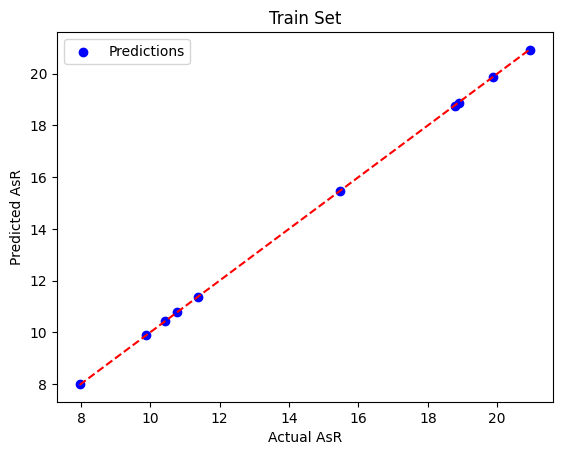

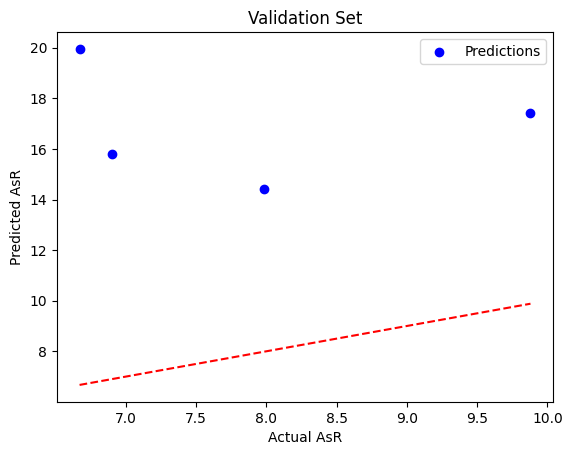

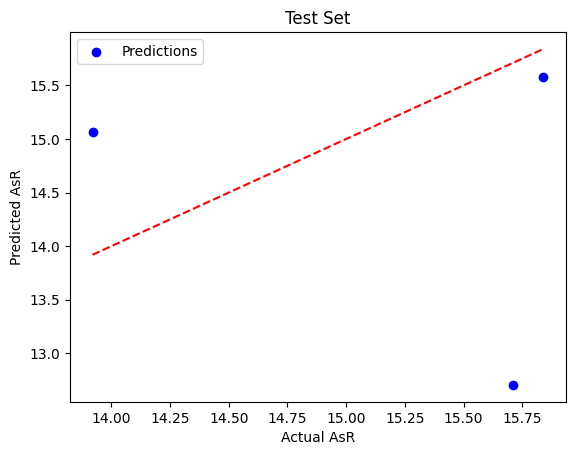


Results exported to: pmf_glwr_xgb_predictions.csv and pmf_glwr_xgb_feature_importance.csv


In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ==================== 1. Load Data ==================== #
data = pd.read_csv("../data/RainySeason.csv")

# Features for PMF (Heavy Metals + Sediment Indices)
pmf_features = ['CrR','NiR','CuR','AsR','CdR','PbR','MR','SandR','SiltR','ClayR','FeR']
X_pmf = data[pmf_features].values
coords = data[['Long', 'Lat']].values
y = data['AsR'].values

# ==================== 2. PMF (NMF) ==================== #
n_sources = 3
nmf = NMF(n_components=n_sources, init='random', random_state=42, max_iter=1000)
G = nmf.fit_transform(X_pmf)   # Source contributions per station
F = nmf.components_            # Source profiles

print("\nPMF Source Profiles (F):\n", pd.DataFrame(F, columns=pmf_features))
print("\nPMF Source Contributions (G):\n", pd.DataFrame(G))

# ==================== 3. Safe GLWR ==================== #
scaler = StandardScaler()
G_scaled = scaler.fit_transform(G)

try:
    sel_bw = Sel_BW(coords, y, G_scaled)  # no min/max args for compatibility
    bw = max(3, min(5, sel_bw.search()))  # clamp bandwidth between 3–5
    gwr_model = GWR(coords, y.reshape(-1,1), G_scaled, bw)
    gwr_results = gwr_model.fit()
    G_glwr = gwr_results.predy.reshape(-1,1)
    print("\nGWR successful. Bandwidth used:", bw)
except Exception as e:
    print("\nGWR failed, using OLS fallback:", e)
    ols = LinearRegression().fit(G_scaled, y)
    G_glwr = ols.predict(G_scaled).reshape(-1,1)

# ==================== 4. Prepare Final Dataset ==================== #
# Other features excluding metadata & target
drop_cols = ['Stations','River','Lat','Long','geometry','AsR']
X_other = data.drop(columns=drop_cols)

# Final input: original features + PMF factors + GLWR adjusted
X_final = np.hstack([X_other.values, G, G_glwr])
feature_names = list(X_other.columns) + [f'PMF_Factor{i+1}' for i in range(n_sources)] + ['GLWR_Adjusted']

# Split indices: 10 train / 4 val / 3 test
train_idx, val_idx, test_idx = np.arange(0,10), np.arange(10,14), np.arange(14,17)
X_train, X_val, X_test = X_final[train_idx], X_final[val_idx], X_final[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

# ==================== 5. Train XGBoost ==================== #
xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
xgb.fit(X_train, y_train)  # removed early_stopping_rounds for compatibility

# Predictions
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

# ==================== 6. Evaluation ==================== #
def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("\nR² Train:", r2_score(y_train, y_pred_train))
print("R² Validation:", r2_score(y_val, y_pred_val))
print("R² Test:", r2_score(y_test, y_pred_test))

print("\nRMSE Train:", rmse(y_train, y_pred_train))
print("RMSE Validation:", rmse(y_val, y_pred_val))
print("RMSE Test:", rmse(y_test, y_pred_test))

# ==================== 7. Feature Importance ==================== #
importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importance:\n", importance)

# ==================== 8. Plot Predicted vs Actual ==================== #
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, color='blue', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual AsR")
    plt.ylabel("Predicted AsR")
    plt.title(title)
    plt.legend()
    plt.show()

plot_pred_vs_actual(y_train, y_pred_train, "Train Set")
plot_pred_vs_actual(y_val, y_pred_val, "Validation Set")
plot_pred_vs_actual(y_test, y_pred_test, "Test Set")

# ==================== 9. Export Results ==================== #
results_df = pd.DataFrame({
    'Station_Index': np.arange(len(y)),
    'Actual_AsR': y,
    'Predicted_AsR': np.concatenate([y_pred_train, y_pred_val, y_pred_test])
})
results_df.to_csv("pmf_glwr_xgb_predictions.csv", index=False)
importance.to_csv("pmf_glwr_xgb_feature_importance.csv", index=False)

print("\nResults exported to: pmf_glwr_xgb_predictions.csv and pmf_glwr_xgb_feature_importance.csv")


PMF Source Profiles (F):
          CrR       NiR        CuR       AsR       CdR        PbR         MR  \
0   0.995010  0.722281   1.792157  0.277015  0.071267   1.933907   0.693186   
1   3.870109  2.944827   7.428200  1.064915  0.632353   6.123407   2.905688   
2  23.844595  8.345690  20.331419  3.749096  0.942587  15.069890  14.705256   

      SandR      SiltR      ClayR           FeR  
0  0.633111   0.798067   0.607420    810.282755  
1  2.473792   1.616742   4.025113   2763.784648  
2  6.462118  23.925160  13.253146  13711.252921  

GWR (Manual Gaussian) completed successfully.

=== K-Fold Cross-Validation Results ===
Ridge: R² = -35.6407, RMSE = 27.9644
Lasso: R² = -47.0514, RMSE = 32.0241
XGBoost: R² = -0.6994, RMSE = 6.0225

XGBoost Feature Importance:
                              Feature  Importance
6                                CuR    0.231203
8                                PbR    0.185072
10                             SandR    0.114211
17                      GWR_Adj

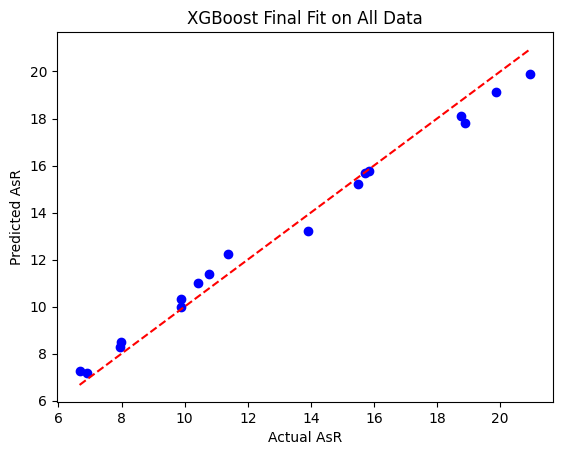


Results exported: predictions & feature importance CSVs.


In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ==================== 1. Load Data ==================== #
data = pd.read_csv("../data/RainySeason.csv")
pmf_features = ['CrR','NiR','CuR','AsR','CdR','PbR','MR','SandR','SiltR','ClayR','FeR']
X_pmf = data[pmf_features].values
coords = data[['Long', 'Lat']].values
y = data['AsR'].values

# ==================== 2. PMF (NMF) ==================== #
n_sources = 3
nmf = NMF(n_components=n_sources, init='random', random_state=42, max_iter=1000)
G = nmf.fit_transform(X_pmf)
F = nmf.components_
print("\nPMF Source Profiles (F):\n", pd.DataFrame(F, columns=pmf_features))

# ==================== 3. Fixed GWR (Manual Gaussian Kernel) ==================== #
def gaussian_kernel(distances, bandwidth):
    return np.exp(-(distances**2)/(2*bandwidth**2))

def fixed_gwr(coords, factors, y, bandwidth=0.5):
    n = len(coords)
    y_pred = np.zeros(n)
    for i in range(n):
        dists = np.linalg.norm(coords - coords[i], axis=1)
        weights = gaussian_kernel(dists, bandwidth)
        W = np.diag(weights)
        X = np.hstack([np.ones((n,1)), factors])
        beta = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y.reshape(-1,1))
        y_pred[i] = (np.array([1] + list(factors[i])) @ beta).item()
    return y_pred.reshape(-1,1)

G_glwr = fixed_gwr(coords, G, y, bandwidth=0.5)
print("\nGWR (Manual Gaussian) completed successfully.")

# ==================== 4. Prepare Final Features ==================== #
drop_cols = ['Stations','River','Lat','Long','geometry','AsR']
X_other = data.drop(columns=drop_cols)
X_final = np.hstack([X_other.values, G, G_glwr])
feature_names = list(X_other.columns) + [f'PMF_Factor{i+1}' for i in range(n_sources)] + ['GWR_Adjusted']

# ==================== 5. Models ==================== #
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.01)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=2, random_state=42)

models = {
    "Ridge": ridge,
    "Lasso": lasso,
    "XGBoost": xgb
}

# ==================== 6. K-Fold Cross-Validation ==================== #
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    y_true_all, y_pred_all = [], []
    for train_idx, test_idx in kf.split(X_final):
        X_tr, X_te = X_final[train_idx], X_final[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_te)
        y_true_all.extend(y_te)
        y_pred_all.extend(preds)
    r2 = r2_score(y_true_all, y_pred_all)
    rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
    results[name] = (r2, rmse)

# Display CV Results
print("\n=== K-Fold Cross-Validation Results ===")
for name, (r2, rmse) in results.items():
    print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

# ==================== 7. Train Final XGBoost on All Data ==================== #
xgb.fit(X_final, y)
final_preds = xgb.predict(X_final)

# ==================== 8. Feature Importance ==================== #
importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nXGBoost Feature Importance:\n", importance)

# ==================== 9. Plot Predictions ==================== #
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual AsR")
    plt.ylabel("Predicted AsR")
    plt.title(title)
    plt.show()

plot_pred_vs_actual(y, final_preds, "XGBoost Final Fit on All Data")

# ==================== 10. Export Results ==================== #
pd.DataFrame({
    'Actual_AsR': y,
    'Predicted_AsR': final_preds
}).to_csv("improved_pmf_gwr_xgb_predictions.csv", index=False)

importance.to_csv("improved_pmf_gwr_xgb_feature_importance.csv", index=False)
print("\nResults exported: predictions & feature importance CSVs.")


In [7]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
from shapely.geometry import Point
import geopandas as gpd
from sklearn.decomposition import NMF, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings("ignore")

# ==================== 1. Load CSV Data ==================== #
data = pd.read_csv("../data/RainySeason.csv")
coords = data[['Long','Lat']].values
target = data['AsR'].values
drop_cols = ['Stations','River','Lat','Long','geometry','AsR']
X_other = data.drop(columns=drop_cols).values

# ==================== 2. PMF (NMF) ==================== #
pmf_features = ['CrR','NiR','CuR','AsR','CdR','PbR','MR','SandR','SiltR','ClayR','FeR']
X_pmf = data[pmf_features].values
nmf = NMF(n_components=3, init='random', random_state=42, max_iter=1000)
G = nmf.fit_transform(X_pmf)
F = nmf.components_
print("\nPMF Source Profiles (F):\n", pd.DataFrame(F, columns=pmf_features))

# ==================== 3. Fixed GWR (Manual Gaussian Kernel) ==================== #
def gaussian_kernel(d, bw): return np.exp(-(d**2)/(2*bw**2))
def fixed_gwr(coords, factors, y, bw=0.5):
    n = len(coords)
    preds = np.zeros(n)
    X = np.hstack([np.ones((n,1)), factors])
    for i in range(n):
        dist = np.linalg.norm(coords - coords[i], axis=1)
        W = np.diag(gaussian_kernel(dist, bw))
        beta = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y.reshape(-1,1))
        preds[i] = (np.array([1] + list(factors[i])) @ beta).item()
    return preds.reshape(-1,1)

G_gwr = fixed_gwr(coords, G, target, bw=0.5)

# ==================== 4. Raster Extraction (4300 m Buffer) ==================== #
raster_paths = [
    "IDW/AsR.tif","IDW/CdR.tif","IDW/ClayR.tif","IDW/CrR.tif",
    "IDW/CuR.tif","IDW/NiR.tif","IDW/Pb_R.tif","IDW/SandR.tif","IDW/SiltR.tif"
]

def extract_raster_values(raster_path, lon, lat, radius=4300):
    with rasterio.open(raster_path) as src:
        # Transform coordinates to raster CRS
        crs = src.crs
        point = gpd.GeoSeries([Point(lon,lat)], crs="EPSG:4326").to_crs(crs)
        buffer = point.buffer(radius).to_crs(crs)
        geojson = [buffer.iloc[0].__geo_interface__]
        img, _ = mask(src, geojson, crop=True)
        vals = img[0].flatten()
        return vals[~np.isnan(vals)]

# Extract all raster values per station
all_raster_values = []
for i, row in data.iterrows():
    features = []
    for r in raster_paths:
        vals = extract_raster_values(r, row['Long'], row['Lat'])
        features.append(vals[:500] if len(vals)>500 else np.pad(vals, (0, max(0,500-len(vals))), 'constant'))
    all_raster_values.append(np.concatenate(features))
all_raster_values = np.array(all_raster_values)

# ==================== 5. PCA on Extracted Raster Features ==================== #
scaler = StandardScaler()
scaled_rasters = scaler.fit_transform(all_raster_values)

# dynamically choose valid number of components
n_components = min(10, scaled_rasters.shape[0] - 1)
pca = PCA(n_components=n_components)
raster_pca = pca.fit_transform(scaled_rasters)
print(f"\nRaster PCA shape: {raster_pca.shape}")

# ==================== 6. Autoencoder Feature Extraction (Optional) ==================== #
def build_autoencoder(input_dim, encoding_dim=10):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(1e-5))(input_layer)
    decoded = Dense(input_dim, activation="sigmoid")(encoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer="adam", loss="mse")
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(raster_pca.shape[1], encoding_dim=10)
autoencoder.fit(raster_pca, raster_pca, epochs=100, batch_size=4, verbose=0)
raster_encoded = encoder.predict(raster_pca)
print(f"Autoencoder Encoded Raster Features Shape: {raster_encoded.shape}")

# ==================== 7. Combine All Features ==================== #
X_final = np.hstack([X_other, G, G_gwr, raster_encoded])
print(f"\nFinal Feature Matrix Shape: {X_final.shape}")

# ==================== 8. Model Training with XGBoost ==================== #
xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_true_all, y_pred_all = [], []

for train_idx, test_idx in kf.split(X_final):
    X_tr, X_te = X_final[train_idx], X_final[test_idx]
    y_tr, y_te = target[train_idx], target[test_idx]
    xgb.fit(X_tr, y_tr)
    preds = xgb.predict(X_te)
    y_true_all.extend(y_te)
    y_pred_all.extend(preds)

r2 = r2_score(y_true_all, y_pred_all)
rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
print(f"\n=== Final Model Performance (5-Fold CV) ===\nR² = {r2:.4f}, RMSE = {rmse:.4f}")

# ==================== 9. Feature Importance ==================== #
importance = pd.DataFrame({
    'Feature': [f"F{i}" for i in range(X_final.shape[1])],
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTop Features:\n", importance.head(15))

# ==================== 10. Save Results ==================== #
pd.DataFrame({
    "Actual_AsR": target,
    "Predicted_AsR": xgb.predict(X_final)
}).to_csv("advanced_raster_pmf_gwr_xgb_predictions.csv", index=False)

importance.to_csv("advanced_feature_importance.csv", index=False)
print("\nResults exported: predictions & feature importance CSVs.")



PMF Source Profiles (F):
          CrR       NiR        CuR       AsR       CdR        PbR         MR  \
0   0.995010  0.722281   1.792157  0.277015  0.071267   1.933907   0.693186   
1   3.870109  2.944827   7.428200  1.064915  0.632353   6.123407   2.905688   
2  23.844595  8.345690  20.331419  3.749096  0.942587  15.069890  14.705256   

      SandR      SiltR      ClayR           FeR  
0  0.633111   0.798067   0.607420    810.282755  
1  2.473792   1.616742   4.025113   2763.784648  
2  6.462118  23.925160  13.253146  13711.252921  

Raster PCA shape: (17, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Autoencoder Encoded Raster Features Shape: (17, 10)

Final Feature Matrix Shape: (17, 28)

=== Final Model Performance (5-Fold CV) ===
R² = -0.8039, RMSE = 6.2048

Top Features:
    Feature  Importance
8       F8    0.508816
16     F16    0.222226
3       F3    0.046697
10     F10    0.042350
1       F1    0.031198
12     F12    0.026565
13     F13    0.023528
2       F2    0.019394
9   


=== Running SHAP Analysis ===


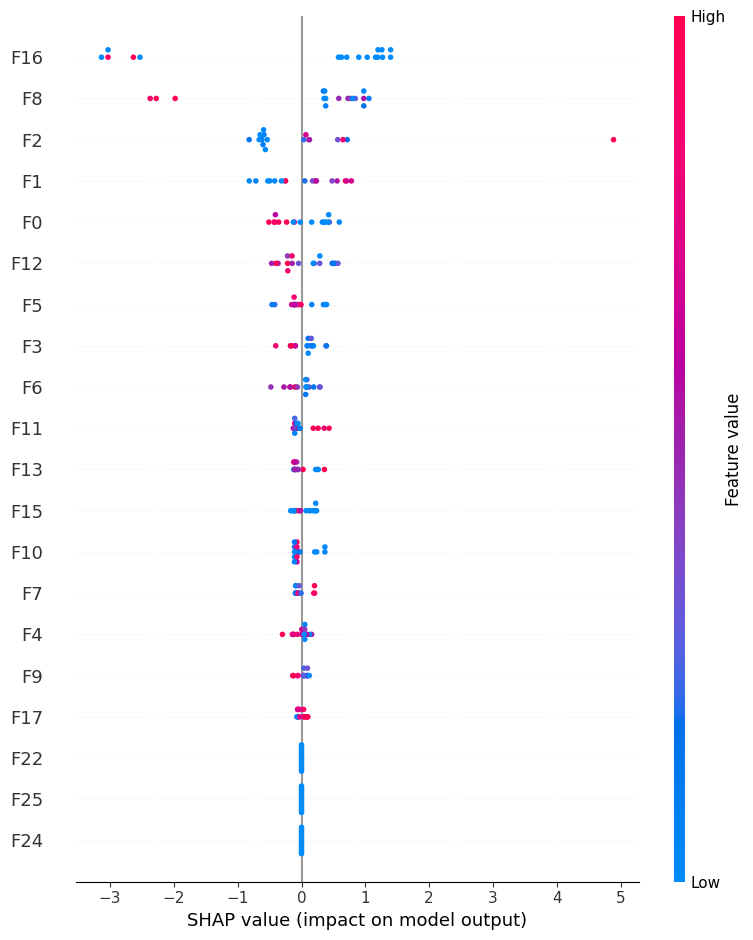

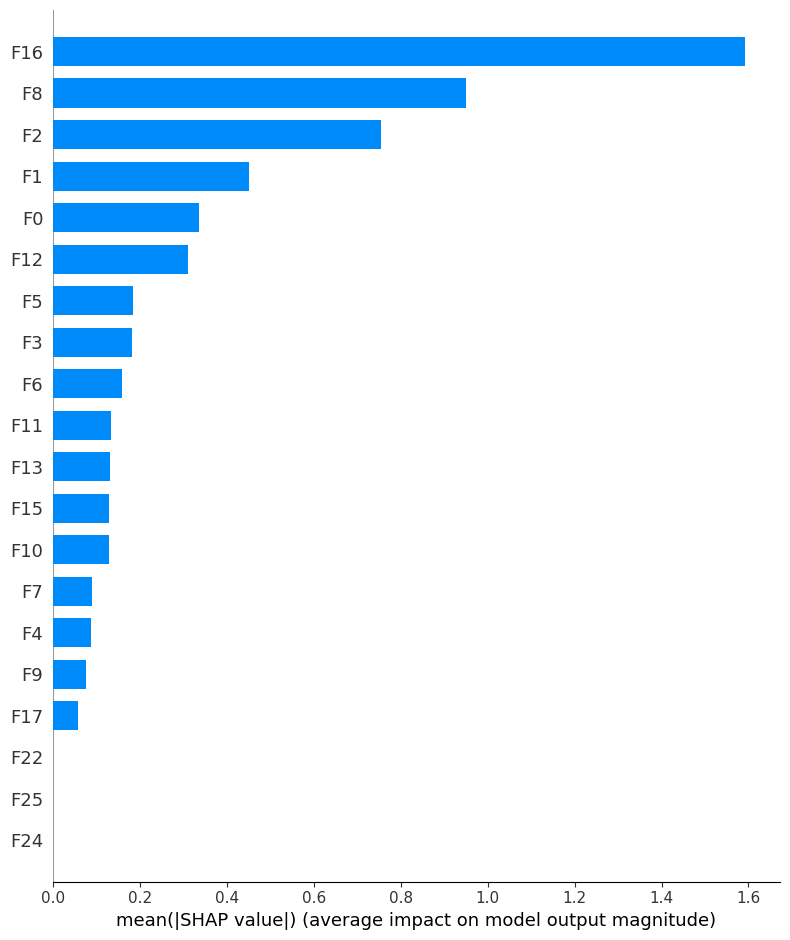

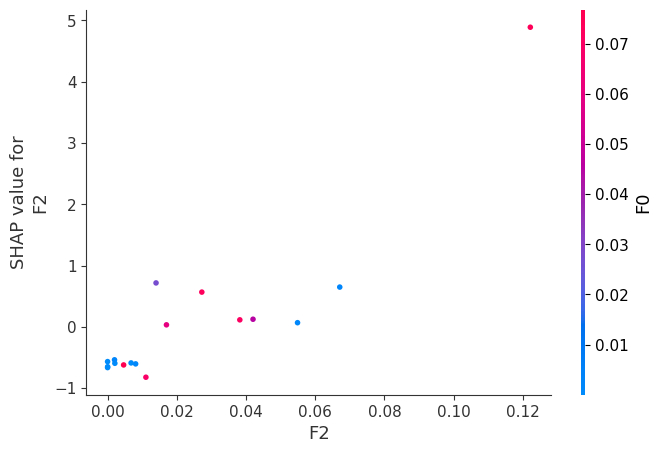

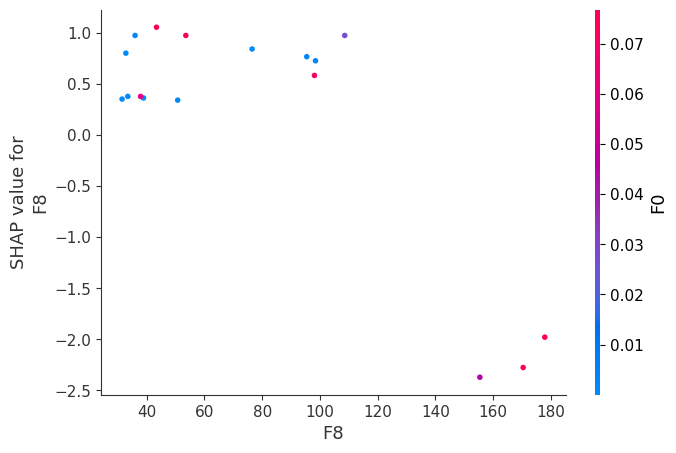

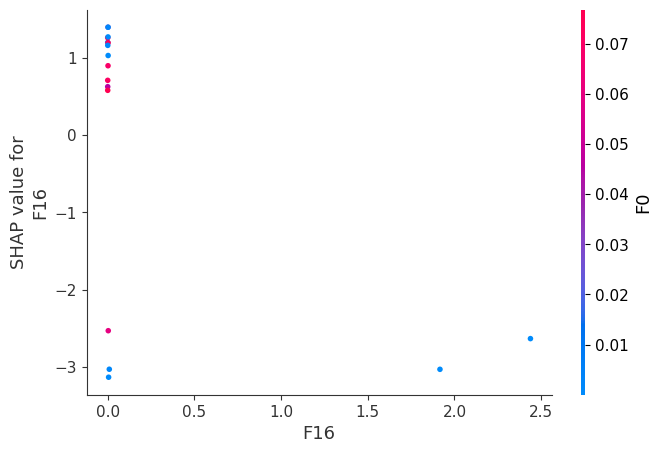

In [8]:
import shap
import matplotlib.pyplot as plt

# ==================== SHAP ANALYSIS ==================== #
print("\n=== Running SHAP Analysis ===")

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_final)

# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values, columns=[f"F{i}" for i in range(X_final.shape[1])])
shap_df["Actual_AsR"] = target
shap_df.to_csv("shap_feature_contributions.csv", index=False)

# ==================== SHAP Plots ==================== #
# 1. Summary Plot (Feature Importance)
shap.summary_plot(shap_values, X_final, feature_names=[f"F{i}" for i in range(X_final.shape[1])], show=True)

# 2. Bar Plot (Mean Absolute SHAP Value)
shap.summary_plot(shap_values, X_final, feature_names=[f"F{i}" for i in range(X_final.shape[1])], plot_type="bar", show=True)

# 3. Dependence Plot for Top Features
top_features = np.argsort(np.abs(shap_values).mean(axis=0))[-3:]  # top 3 features
for f in top_features:
    shap.dependence_plot(f, shap_values, X_final, feature_names=[f"F{i}" for i in range(X_final.shape[1])])


In [12]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape, LineString, Point
from scipy.spatial import cKDTree
import cv2

# ======== 1. Load NDWI Raster ======== #
ndwi_path = "CalIndices/ndwi.tif"
with rasterio.open(ndwi_path) as src:
    ndwi = src.read(1)
    ndwi[ndwi < -1] = np.nan  # mask invalid
    transform = src.transform
    crs = src.crs

# ======== 2. Extract Water Mask (NDWI > 0.3) ======== #
water_mask = (ndwi > 0.3).astype(np.uint8)  # binary water mask

# ======== 3. Vectorize Water Bodies ======== #
shapes_gen = shapes(water_mask, mask=water_mask, transform=transform)
polygons = [shape(geom) for geom, val in shapes_gen if val == 1]
water_gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)

# ======== 4. Create River Centerline ======== #
# Simplify by taking boundaries and applying skeletonization
mask_uint8 = (water_mask * 255).astype(np.uint8)
skeleton = cv2.ximgproc.thinning(mask_uint8) if hasattr(cv2, 'ximgproc') else mask_uint8
# Convert skeleton pixels to coordinates
river_points = np.column_stack(np.where(skeleton > 0))
river_coords = [~transform * (c[1], c[0]) for c in river_points]  # convert to lon,lat
river_line = LineString(river_coords)  # rough centerline

# ======== 5. Sample 100 Points Along River Line ======== #
distances = np.linspace(0, river_line.length, 100)
sampled_points = [river_line.interpolate(d) for d in distances]
river_sample_gdf = gpd.GeoDataFrame(geometry=sampled_points, crs=crs)
river_sample_gdf = river_sample_gdf.to_crs("EPSG:4326")  # to lat/lon

# Extract coordinates
river_coords_100 = np.array([[p.x, p.y] for p in river_sample_gdf.geometry])

# ======== 6. IDW Interpolation for Features ======== #
data = pd.read_csv("../data/RainySeason.csv")
coords = data[['Long','Lat']].values
target = data['AsR'].values
drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_features = data.drop(columns=drop_cols).drop(columns=['AsR'])

def idw_interpolation(known_coords, known_values, query_coords, power=2):
    tree = cKDTree(known_coords)
    dists, idxs = tree.query(query_coords, k=4)
    dists[dists == 0] = 1e-10
    weights = 1 / (dists ** power)
    weights /= weights.sum(axis=1)[:, None]
    return np.sum(weights * known_values[idxs], axis=1)

# Interpolate features and AsR
interpolated_features = np.zeros((len(river_coords_100), numeric_features.shape[1]))
for i, col in enumerate(numeric_features.columns):
    interpolated_features[:, i] = idw_interpolation(coords, numeric_features[col].values, river_coords_100)

interpolated_AsR = idw_interpolation(coords, target, river_coords_100)

# ======== 7. Create River Sampling Dataset ======== #
river_df = pd.DataFrame(interpolated_features, columns=numeric_features.columns)
river_df['Long'] = river_coords_100[:, 0]
river_df['Lat'] = river_coords_100[:, 1]
river_df['AsR'] = interpolated_AsR
river_df['Source'] = 'River_Interpolated'

river_df.to_csv("river_100_samples.csv", index=False)
print("✅ Generated 100 river-interpolated samples. Shape:", river_df.shape)

✅ Generated 100 river-interpolated samples. Shape: (100, 18)


## 100 Data generate

In [15]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape, Point
from scipy.spatial import cKDTree
import folium

# ===================== 1. Load NDWI Raster ===================== #
ndwi_path = "CalIndices/ndwi.tif"
with rasterio.open(ndwi_path) as src:
    ndwi = src.read(1)
    ndwi[ndwi < -1] = np.nan
    transform = src.transform
    crs = src.crs

# ===================== 2. Extract Water Mask (NDWI > 0.3) ===================== #
water_mask = (ndwi > 0.3).astype(np.uint8)

# ===================== 3. Vectorize Water Polygons ===================== #
shapes_gen = shapes(water_mask, mask=water_mask, transform=transform)
polygons = [shape(geom) for geom, val in shapes_gen if val == 1]
water_gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
water_gdf = water_gdf.to_crs("EPSG:4326")  # convert to lat/lon

# ===================== 4. Sample 100 Random Points Within River Polygons ===================== #
np.random.seed(42)
sampled_points = []
for _ in range(100):
    poly = water_gdf.sample(1).geometry.values[0]
    minx, miny, maxx, maxy = poly.bounds
    # random point inside polygon
    while True:
        p = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if poly.contains(p):
            sampled_points.append(p)
            break

river_sample_gdf = gpd.GeoDataFrame(geometry=sampled_points, crs="EPSG:4326")
river_coords_100 = np.array([[p.x, p.y] for p in river_sample_gdf.geometry])

# ===================== 5. Load Original Data ===================== #
data = pd.read_csv("../data/RainySeason.csv")
coords = data[['Long', 'Lat']].values
target = data['AsR'].values
drop_cols = ['Stations', 'River', 'Lat', 'Long', 'geometry']
numeric_features = data.drop(columns=drop_cols).drop(columns=['AsR'])

# ===================== 6. Define IDW Interpolation ===================== #
def idw_interpolation(known_coords, known_values, query_coords, power=2):
    tree = cKDTree(known_coords)
    dists, idxs = tree.query(query_coords, k=4)  # 4 nearest neighbors
    dists[dists == 0] = 1e-10
    weights = 1 / (dists ** power)
    weights /= weights.sum(axis=1)[:, None]
    return np.sum(weights * known_values[idxs], axis=1)

# ===================== 7. Interpolate Features & Target for 100 River Points ===================== #
interpolated_features = np.zeros((len(river_coords_100), numeric_features.shape[1]))
for i, col in enumerate(numeric_features.columns):
    interpolated_features[:, i] = idw_interpolation(coords, numeric_features[col].values, river_coords_100)

interpolated_AsR = idw_interpolation(coords, target, river_coords_100)

# ===================== 8. Create River Sampling Dataset ===================== #
river_df = pd.DataFrame(interpolated_features, columns=numeric_features.columns)
river_df['Long'] = river_coords_100[:, 0]
river_df['Lat'] = river_coords_100[:, 1]
river_df['AsR'] = interpolated_AsR
river_df['Source'] = 'River_Interpolated'

river_df.to_csv("river_100_samples.csv", index=False)
print("✅ Generated 100 river-interpolated samples. Shape:", river_df.shape)

# ===================== 9. Visualize on Interactive Folium Map ===================== #
center_lat, center_lon = river_df.Lat.mean(), river_df.Long.mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="OpenStreetMap")

# Add water polygons as blue overlay
for poly in water_gdf.geometry:
    folium.GeoJson(poly.__geo_interface__, style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 1, 'fillOpacity': 0.2}).add_to(m)

# Add sampled points
for _, row in river_df.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius=3,
        color='cyan',
        fill=True,
        fill_color='blue',
        popup=f"AsR (Interpolated): {row['AsR']:.2f}"
    ).add_to(m)

m.save("river_sampling_points_map.html")
print("✅ Interactive map saved as 'river_sampling_points_map.html'. Open it in your browser.")

✅ Generated 100 river-interpolated samples. Shape: (100, 18)
✅ Interactive map saved as 'river_sampling_points_map.html'. Open it in your browser.


## 100 training

In [16]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from scipy.spatial import cKDTree

# ========= 1. Load Datasets ========= #
original = pd.read_csv("../data/RainySeason.csv")
river_100 = pd.read_csv("river_100_samples.csv")

# Extract original numerical features
drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = original.drop(columns=drop_cols).columns.drop('AsR')
coords_orig = original[['Long','Lat']].values

# ========= 2. Split Original Data ========= #
np.random.seed(42)
train_idx = np.random.choice(len(original), 10, replace=False)
test_idx = [i for i in range(len(original)) if i not in train_idx]

train_orig = original.iloc[train_idx]
test_orig = original.iloc[test_idx]

# ========= 3. Combine Training Data ========= #
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ========= 4. PMF (NMF) on Training Data ========= #
pmf_features = ['CrR','NiR','CuR','AsR','CdR','PbR','MR','SandR','SiltR','ClayR','FeR']
nmf = NMF(n_components=3, init='random', random_state=42, max_iter=1000)
G_train = nmf.fit_transform(train_combined[pmf_features])
F = nmf.components_
print("\nPMF Source Profiles (F):\n", pd.DataFrame(F, columns=pmf_features))

# ========= 5. Fixed GWR (Manual Gaussian Kernel) ========= #
def gaussian_kernel(d, bw): return np.exp(-(d**2)/(2*bw**2))
def fixed_gwr(coords, factors, y, bw=0.5):
    n = len(coords)
    preds = np.zeros(n)
    X = np.hstack([np.ones((n,1)), factors])
    for i in range(n):
        dist = np.linalg.norm(coords - coords[i], axis=1)
        W = np.diag(gaussian_kernel(dist, bw))
        beta = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y.reshape(-1,1))
        preds[i] = (np.array([1] + list(factors[i])) @ beta).item()
    return preds.reshape(-1,1)

coords_train = train_combined[['Long','Lat']].values
y_train = train_combined['AsR'].values
GWR_train = fixed_gwr(coords_train, G_train, y_train, bw=0.5)

# ========= 6. Prepare Training Features ========= #
X_train = np.hstack([train_combined[numeric_cols].values, G_train, GWR_train])

# ========= 7. Prepare Test Features ========= #
coords_test = test_orig[['Long','Lat']].values
y_test = test_orig['AsR'].values

# Interpolate PMF factors for test points using IDW
def idw_interpolation(known_coords, known_values, query_coords, power=2):
    tree = cKDTree(known_coords)
    dists, idxs = tree.query(query_coords, k=4)
    dists[dists == 0] = 1e-10
    weights = 1 / (dists ** power)
    weights /= weights.sum(axis=1)[:, None]
    return np.sum(weights * known_values[idxs], axis=1)

G_test = np.column_stack([idw_interpolation(coords_train, G_train[:, i], coords_test) for i in range(G_train.shape[1])])
GWR_test = fixed_gwr(coords_test, G_test, y_test, bw=0.5)
X_test = np.hstack([test_orig[numeric_cols].values, G_test, GWR_test])

# ========= 8. Train XGBoost ========= #
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, reg_lambda=5, reg_alpha=2, random_state=42)
xgb.fit(X_train, y_train)

# ========= 9. Evaluate ========= #
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\n✅ Model Performance:")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# ========= 10. Feature Importance ========= #
importance = pd.DataFrame({
    'Feature': [f"F{i}" for i in range(X_train.shape[1])],
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features:\n", importance.head(10))
importance.to_csv("feature_importance_river_train.csv", index=False)



PMF Source Profiles (F):
          CrR        NiR        CuR       AsR       CdR        PbR         MR  \
0   1.252834   0.620734   1.660758  0.283671  0.079194   1.611324   0.714773   
1   5.130533   2.638791   5.512220  1.278865  0.239088   4.676907   3.156905   
2  30.627376  13.469987  28.805434  6.113805  1.687654  26.763262  15.087062   

       SandR      SiltR      ClayR           FeR  
0   0.542379   0.897948   0.684192    772.311833  
1   3.608799   3.568484   2.435789   2884.100205  
2  15.171783  16.682466  13.923366  13360.179207  

✅ Model Performance:
R² Train: 0.9944 | RMSE Train: 0.2451
R² Test: 0.7388 | RMSE Test: 2.6111

Top Features:
    Feature  Importance
12     F12    0.232530
2       F2    0.191479
6       F6    0.140614
4       F4    0.077792
16     F16    0.072213
3       F3    0.065123
8       F8    0.042276
0       F0    0.036995
5       F5    0.036654
7       F7    0.034749


[I 2025-08-06 15:59:28,367] A new study created in memory with name: no-name-eecbd4bd-c041-4d5d-87c4-3c5d3ac83e67
[I 2025-08-06 15:59:28,423] Trial 0 finished with value: -0.7472319506028663 and parameters: {'n_estimators': 203, 'learning_rate': 0.20956075891081813, 'max_depth': 4, 'subsample': 0.9580518629718972, 'colsample_bytree': 0.8396290102124013, 'reg_lambda': 1.464868048392808, 'reg_alpha': 0.4910233127550123}. Best is trial 0 with value: -0.7472319506028663.
[I 2025-08-06 15:59:28,517] Trial 1 finished with value: -0.6836636326110512 and parameters: {'n_estimators': 583, 'learning_rate': 0.15486825841935975, 'max_depth': 6, 'subsample': 0.8519983879274635, 'colsample_bytree': 0.7405260978367381, 'reg_lambda': 3.7942176282793443, 'reg_alpha': 2.907858242004107}. Best is trial 0 with value: -0.7472319506028663.



PMF Source Profiles (F):
          CrR        NiR        CuR       AsR       CdR        PbR         MR  \
0   1.252834   0.620734   1.660758  0.283671  0.079194   1.611324   0.714773   
1   5.130533   2.638791   5.512220  1.278865  0.239088   4.676907   3.156905   
2  30.627376  13.469987  28.805434  6.113805  1.687654  26.763262  15.087062   

       SandR      SiltR      ClayR           FeR  
0   0.542379   0.897948   0.684192    772.311833  
1   3.608799   3.568484   2.435789   2884.100205  
2  15.171783  16.682466  13.923366  13360.179207  


[I 2025-08-06 15:59:28,622] Trial 2 finished with value: -0.6619593776000381 and parameters: {'n_estimators': 466, 'learning_rate': 0.07478266787417592, 'max_depth': 3, 'subsample': 0.7673269212556308, 'colsample_bytree': 0.9445895905604392, 'reg_lambda': 8.180943434885812, 'reg_alpha': 3.4907925837568032}. Best is trial 0 with value: -0.7472319506028663.
[I 2025-08-06 15:59:28,751] Trial 3 finished with value: -0.6655830852510525 and parameters: {'n_estimators': 539, 'learning_rate': 0.253232056477262, 'max_depth': 3, 'subsample': 0.6680609423307627, 'colsample_bytree': 0.992696859806928, 'reg_lambda': 3.609391001583068, 'reg_alpha': 3.8040614754322863}. Best is trial 0 with value: -0.7472319506028663.
[I 2025-08-06 15:59:28,815] Trial 4 finished with value: -0.698143480631553 and parameters: {'n_estimators': 334, 'learning_rate': 0.17907543028288492, 'max_depth': 6, 'subsample': 0.6138249482847846, 'colsample_bytree': 0.8582127088459045, 'reg_lambda': 2.3299579585291506, 'reg_alpha':


✅ Best Parameters from Optuna: {'n_estimators': 265, 'learning_rate': 0.29273950963764506, 'max_depth': 6, 'subsample': 0.7584485139358651, 'colsample_bytree': 0.6992709902871281, 'reg_lambda': 4.681023742703092, 'reg_alpha': 1.9036462605191509}

✅ Final Model Performance:
R² Train: 0.9969 | RMSE Train: 0.1827
R² Test: 0.7963 | RMSE Test: 2.3060


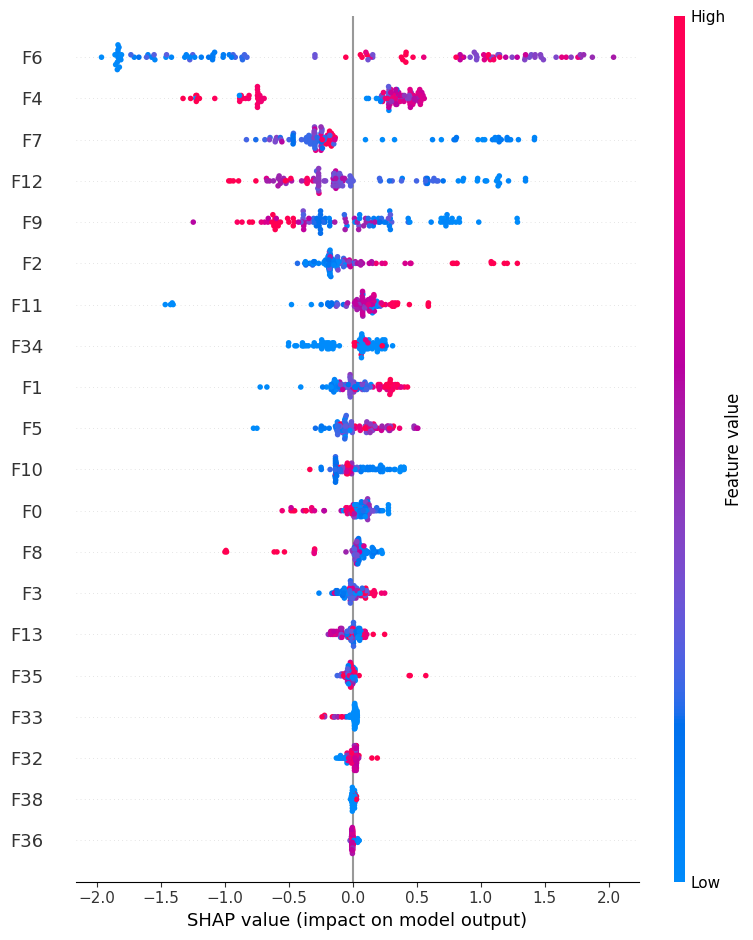

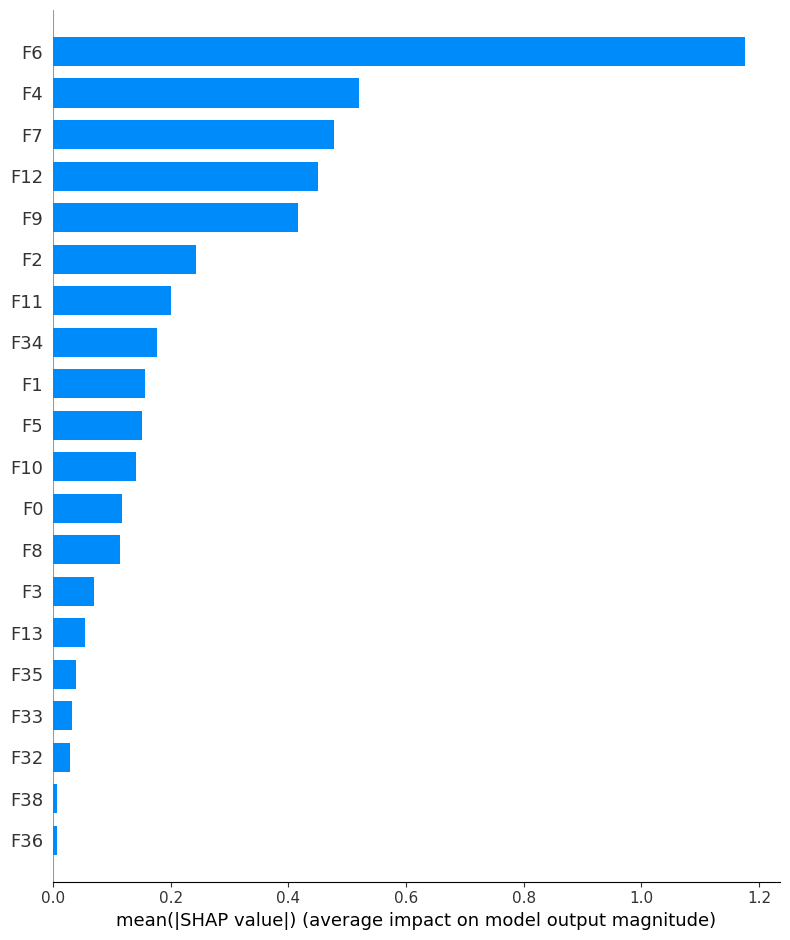

✅ SHAP analysis complete. Check plots for feature importance.


In [20]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
import rasterstats
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import optuna
import shap
from scipy.spatial import cKDTree

# ==================== 1. Load Data ==================== #
original = pd.read_csv("../data/RainySeason.csv")
river_100 = pd.read_csv("river_100_samples.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = original.drop(columns=drop_cols).columns.drop('AsR')

# Split original into train/test
np.random.seed(42)
train_idx = np.random.choice(len(original), 10, replace=False)
test_idx = [i for i in range(len(original)) if i not in train_idx]
train_orig = original.iloc[train_idx]
test_orig = original.iloc[test_idx]

# Combine training: 100 river samples + 10 original
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Extract Multi-Scale Raster Features ==================== #
raster_files = [
    "CalIndices/ndwi.tif", "CalIndices/ndvi.tif", "CalIndices/ndbi.tif"
]  # add more if needed
buffers = [500, 1000, 2000]

from rasterstats import zonal_stats

def extract_raster_stats(points_df, rasters, buffers):
    gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df.Long, points_df.Lat), crs="EPSG:4326")
    features = pd.DataFrame(index=gdf.index)
    
    for raster in rasters:
        for buf in buffers:
            col_mean = f"{raster.split('/')[-1].split('.')[0]}_{buf}m_mean"
            col_std = f"{raster.split('/')[-1].split('.')[0]}_{buf}m_std"
            
            means, stds = [], []
            for geom in gdf.geometry.buffer(buf / 111320):  # buffer in degrees
                zs = zonal_stats([geom], raster, stats=['mean', 'std'], nodata=np.nan)
                means.append(zs[0]['mean'])
                stds.append(zs[0]['std'])
            
            features[col_mean] = means
            features[col_std] = stds
    
    return features
    
# Extract raster features for train/test
train_raster_feats = extract_raster_stats(train_combined, raster_files, buffers)
test_raster_feats = extract_raster_stats(test_orig, raster_files, buffers)

# ==================== 3. PMF (NMF) ==================== #
pmf_features = ['CrR','NiR','CuR','AsR','CdR','PbR','MR','SandR','SiltR','ClayR','FeR']
nmf = NMF(n_components=3, init='random', random_state=42, max_iter=1000)
G_train = nmf.fit_transform(train_combined[pmf_features])
F = nmf.components_
print("\nPMF Source Profiles (F):\n", pd.DataFrame(F, columns=pmf_features))

# ==================== 4. Fixed GWR ==================== #
def gaussian_kernel(d, bw): return np.exp(-(d**2)/(2*bw**2))
def fixed_gwr(coords, factors, y, bw=0.5):
    n = len(coords)
    preds = np.zeros(n)
    X = np.hstack([np.ones((n,1)), factors])
    for i in range(n):
        dist = np.linalg.norm(coords - coords[i], axis=1)
        W = np.diag(gaussian_kernel(dist, bw))
        beta = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y.reshape(-1,1))
        preds[i] = (np.array([1] + list(factors[i])) @ beta).item()
    return preds.reshape(-1,1)

coords_train = train_combined[['Long','Lat']].values
y_train = train_combined['AsR'].values
GWR_train = fixed_gwr(coords_train, G_train, y_train, bw=0.5)

# Interpolate PMF for test
def idw_interpolation(known_coords, known_values, query_coords, power=2):
    tree = cKDTree(known_coords)
    dists, idxs = tree.query(query_coords, k=4)
    dists[dists == 0] = 1e-10
    weights = 1 / (dists ** power)
    weights /= weights.sum(axis=1)[:, None]
    return np.sum(weights * known_values[idxs], axis=1)

coords_test = test_orig[['Long','Lat']].values
y_test = test_orig['AsR'].values
G_test = np.column_stack([idw_interpolation(coords_train, G_train[:, i], coords_test) for i in range(G_train.shape[1])])
GWR_test = fixed_gwr(coords_test, G_test, y_test, bw=0.5)

# ==================== 5. Interaction Features ==================== #
def create_interactions(df, pmf, gwr):
    interactions = pd.DataFrame()
    for i in range(pmf.shape[1]):
        interactions[f"PMF{i}_GWR"] = pmf[:, i] * gwr.flatten()
    return interactions

train_interact = create_interactions(train_combined, G_train, GWR_train)
test_interact = create_interactions(test_orig, G_test, GWR_test)

# ==================== 6. Final Feature Matrix ==================== #
X_train = np.hstack([
    train_combined[numeric_cols].values,
    train_raster_feats.values,
    G_train,
    GWR_train,
    train_interact.values
])

X_test = np.hstack([
    test_orig[numeric_cols].values,
    test_raster_feats.values,
    G_test,
    GWR_test,
    test_interact.values
])

# ==================== 7. Optuna Hyperparameter Optimization ==================== #
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5)
    }
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -r2_score(y_test, y_pred)  # minimize negative R²

import optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)
best_params = study.best_params
print("\n✅ Best Parameters from Optuna:", best_params)

# ==================== 8. Train Final XGBoost ==================== #
xgb = XGBRegressor(**best_params, random_state=42)
xgb.fit(X_train, y_train)

# ==================== 9. Evaluation ==================== #
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\n✅ Final Model Performance:")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# ==================== 10. SHAP Interpretation ==================== #
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])])
shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])], plot_type="bar")

print("✅ SHAP analysis complete. Check plots for feature importance.")


In [21]:
import pandas as pd

# Get feature names (match to X_train columns)
feature_names = list(numeric_cols) \
                + list(train_raster_feats.columns) \
                + [f"PMF_Factor{i}" for i in range(G_train.shape[1])] \
                + ["GWR_Adjusted"] \
                + list(train_interact.columns)

# Create DataFrame of importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Save & print
importance_df.to_csv("final_feature_importance.csv", index=False)
print("\n✅ Top Features (XGBoost Gain):\n", importance_df.head(20))



✅ Top Features (XGBoost Gain):
                              Feature  Importance
4                                CrR    0.155007
6                                CuR    0.124394
12                             ClayR    0.118292
7                                CdR    0.106715
11                             SiltR    0.106221
8                                PbR    0.061570
9                                 MR    0.061018
5                                NiR    0.048092
2   hydrological_dist_to_nearest_IND    0.046549
35                      GWR_Adjusted    0.044150
34                       PMF_Factor2    0.030558
10                             SandR    0.030051
0    hydrological_dist_to_nearest_BF    0.022705
13                               FeR    0.017429
1                    num_upstream_BF    0.013515
3                   num_upstream_IND    0.006326
32                       PMF_Factor0    0.002714
36                          PMF0_GWR    0.001831
33                       PMF_Factor1

In [22]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import glob
import os
from scipy.spatial import distance_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../data/RainySeason.csv")
river_100 = pd.read_csv("river_100_samples.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('AsR')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig  = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("CalIndices/*.tif")
raster_paths += glob.glob("LULCMerged/*.tif")
raster_paths += glob.glob("IDW/*.tif")

print(f"✅ Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 3. Extract CNN Patches ==================== #
def extract_patch(coords, raster_files, patch_size=64):
    half = patch_size//2
    patches = []
    for lon, lat in coords:
        channels = []
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col-half, row-half, patch_size, patch_size)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)
                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except:
                    arr = np.zeros((patch_size, patch_size), dtype=np.float32)
                channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    return np.array(patches)

cnn_train = extract_patch(train_combined[['Long','Lat']].values, raster_paths)
cnn_test  = extract_patch(test_orig[['Long','Lat']].values, raster_paths)

# ==================== 4. Prepare GNN Input ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test  = test_orig[['Long','Lat']].values
dist_mat = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat/10)
gnn_test  = np.exp(-distance_matrix(coords_test, coords_train)/10)

# ==================== 5. Prepare MLP Input ==================== #
scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test  = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['AsR'].values
y_test  = test_orig['AsR'].values

# ==================== 6. Define Enhanced CNN–GNN–MLP Model ==================== #
def build_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # CNN branch (for raster data)
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    x = Conv2D(32, (3,3), activation="relu")(cnn_input)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation="relu")(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    cnn_out = Dense(128, activation="relu", name="cnn_out")(x)

    # MLP branch (for numerical site features)
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    m = Dense(64, activation="relu")(mlp_input)
    mlp_out = Dense(32, activation="relu", name="mlp_out")(m)

    # GNN branch (for spatial connectivity)
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    g = Dense(64, activation="relu")(gnn_input)
    gnn_out = Dense(32, activation="relu", name="gnn_out")(g)

    # Fusion Layer
    combined = Concatenate()([cnn_out, mlp_out, gnn_out])
    f = Dense(128, activation="relu")(combined)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

model = build_fusion_model(cnn_train.shape[1:], gnn_train.shape[1], mlp_train.shape[1])
model.summary()

# ==================== 7. Train Model ==================== #
history = model.fit(
    [cnn_train, mlp_train, gnn_train], y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=4,
    verbose=1
)

# ==================== 8. Evaluate ==================== #
y_pred_train = model.predict([cnn_train, mlp_train, gnn_train]).flatten()
y_pred_test  = model.predict([cnn_test, mlp_test, gnn_test]).flatten()

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\n✅ Enhanced CNN–GNN–MLP Model Performance (All Rasters):")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")


✅ Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        960 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      7,104 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_out (Dense)     │ (None, 128)       │  1,605,760 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_out (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_out (Dense)     │ (None, 32)        │      2,080 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ cnn_out[0][0],    │
│ (Concatenate)       │                   │            │ mlp_out[0][0],    │
│                     │                   │            │ gnn_out[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     24,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         65 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,677,025 (6.40 MB)

 Trainable params: 1,677,025 (6.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 24908.4102 - val_loss: 1015.6849
Epoch 2/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2340.5674 - val_loss: 352.6250
Epoch 3/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1405.5571 - val_loss: 167.1802
Epoch 4/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 725.9866 - val_loss: 142.2824
Epoch 5/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 327.7372 - val_loss: 126.0925
Epoch 6/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 280.0107 - val_loss: 107.2882
Epoch 7/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 227.8351 - val_loss: 57.0605
Epoch 8/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 157.7763 - val_loss: 35.9402
Epoch 9/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 160.7999 - val_loss: 29.3185
Epoch 10/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 169.0166 - val_loss: 25.3328
Epoch 11/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 99.6584 - val_loss: 19.0515
Epoch 12/60
22/22 ━━

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout,
                                     Concatenate, GlobalAveragePooling2D, Multiply, Reshape, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# --- Channel Attention (SE Block) ---
def channel_attention(x, ratio=8):
    filters = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Dense(filters // ratio, activation="relu")(se)
    se = Dense(filters, activation="sigmoid")(se)
    se = Reshape((1,1,filters))(se)
    return Multiply()([x, se])

# --- Build Improved CNN–GNN–MLP ---
def build_improved_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # CNN Branch
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    c = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    c = BatchNormalization()(c)
    c = Conv2D(64, (3,3), activation="relu", padding="same")(c)
    c = BatchNormalization()(c)
    c = MaxPooling2D((2,2))(c)
    c = channel_attention(c)                # ✅ Channel Attention
    c = Conv2D(128, (3,3), activation="relu", padding="same")(c)
    c = MaxPooling2D((2,2))(c)
    c = Flatten()(c)
    cnn_out = Dense(128, activation="relu", name="cnn_out")(c)
    cnn_out = Dropout(0.4)(cnn_out)

    # MLP Branch
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    m = Dense(64, activation="relu")(mlp_input)
    m = BatchNormalization()(m)
    mlp_out = Dense(32, activation="relu", name="mlp_out")(m)

    # GNN Branch
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    g = Dense(64, activation="relu")(gnn_input)
    g = BatchNormalization()(g)
    gnn_out = Dense(32, activation="relu", name="gnn_out")(g)

    # Fusion with Attention
    fusion = Concatenate()([cnn_out, mlp_out, gnn_out])
    f = Dense(128, activation="relu")(fusion)
    f = Dropout(0.3)(f)
    f = Dense(64, activation="relu")(f)
    f = Dropout(0.2)(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# --- Build Model ---
model = build_improved_fusion_model(cnn_train.shape[1:], gnn_train.shape[1], mlp_train.shape[1])
model.summary()

# --- Callbacks for Training ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
]

# --- Train Model ---
history = model.fit(
    [cnn_train, mlp_train, gnn_train], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=4,
    verbose=1,
    callbacks=callbacks
)

# --- Evaluate Model ---
y_pred_train = model.predict([cnn_train, mlp_train, gnn_train]).flatten()
y_pred_test  = model.predict([cnn_test, mlp_test, gnn_test]).flatten()

from sklearn.metrics import r2_score, mean_squared_error
print("\n✅ Improved Custom CNN–GNN–MLP Model Performance:")
print(f"R² Train: {r2_score(y_train, y_pred_train):.4f} | RMSE Train: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"R² Test:  {r2_score(y_test, y_pred_test):.4f} | RMSE Test:  {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │        520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │        576 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ multiply[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │        960 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      7,104 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_out (Dense)     │ (None, 128)       │  4,194,432 │ flatten_1[0][0] 

 Total params: 4,341,545 (16.56 MB)

 Trainable params: 4,341,097 (16.56 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 120.5793 - val_loss: 157.6439 - learning_rate: 5.0000e-04
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 45.5505 - val_loss: 156.8738 - learning_rate: 5.0000e-04
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 51.4850 - val_loss: 152.7150 - learning_rate: 5.0000e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 39.9765 - val_loss: 97.4965 - learning_rate: 5.0000e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 26.8647 - val_loss: 79.8913 - learning_rate: 5.0000e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 26.6822 - val_loss: 106.0618 - learning_rate: 5.0000e-04
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 22.8814 - val_loss: 77.7715 - learning_rate: 5.0000e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 21.7435 - val_loss: 45.4452 - learning_rate: 5.0000e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 27.1845

In [24]:
import optuna
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout,
                                     Concatenate, BatchNormalization)
from tensorflow.keras.optimizers import Adam

# === Objective Function for Optuna ===
def objective(trial):
    # Hyperparameters to optimize
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    cnn_filters = trial.suggest_categorical("cnn_filters", [32, 64, 128])
    dense_units = trial.suggest_categorical("dense_units", [32, 64, 128])
    dropout_rate = trial.suggest_uniform("dropout", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 8])
    
    # Build Model
    cnn_input = Input(shape=cnn_train.shape[1:], name="cnn_input")
    c = Conv2D(cnn_filters, (3,3), activation="relu", padding="same")(cnn_input)
    c = BatchNormalization()(c)
    c = Conv2D(cnn_filters*2, (3,3), activation="relu", padding="same")(c)
    c = MaxPooling2D((2,2))(c)
    c = Flatten()(c)
    cnn_out = Dense(dense_units, activation="relu")(c)
    
    mlp_input = Input(shape=(mlp_train.shape[1],), name="mlp_input")
    m = Dense(dense_units, activation="relu")(mlp_input)
    
    gnn_input = Input(shape=(gnn_train.shape[1],), name="gnn_input")
    g = Dense(dense_units, activation="relu")(gnn_input)
    
    fusion = Concatenate()([cnn_out, m, g])
    f = Dense(dense_units, activation="relu")(fusion)
    f = Dropout(dropout_rate)(f)
    output = Dense(1, activation="linear")(f)
    
    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    
    # Train
    history = model.fit(
        [cnn_train, mlp_train, gnn_train], y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=batch_size,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    )
    
    # Evaluate on validation
    y_val_pred = model.predict([cnn_train, mlp_train, gnn_train], verbose=0).flatten()
    r2 = r2_score(y_train, y_val_pred)
    return -r2  # Optuna minimizes objective, so we use -R²

# === Run Optuna Search ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # try 30 combinations

# === Best Parameters ===
best_params = study.best_params
print("\n✅ Best Hyperparameters Found:")
print(best_params)


[I 2025-08-06 16:17:42,662] A new study created in memory with name: no-name-422373ef-017e-4171-839c-781021426f45


[I 2025-08-06 16:17:59,249] Trial 0 finished with value: -0.3354827098959069 and parameters: {'lr': 0.00033129624318149336, 'cnn_filters': 32, 'dense_units': 32, 'dropout': 0.2983728812904323, 'batch_size': 4}. Best is trial 0 with value: -0.3354827098959069.
[I 2025-08-06 16:18:44,146] Trial 1 finished with value: -0.11897443410851716 and parameters: {'lr': 0.0005067447759732442, 'cnn_filters': 128, 'dense_units': 32, 'dropout': 0.22119883479713384, 'batch_size': 8}. Best is trial 0 with value: -0.3354827098959069.
[I 2025-08-06 16:19:13,055] Trial 2 finished with value: -0.6198044724462294 and parameters: {'lr': 0.0007000777720084342, 'cnn_filters': 64, 'dense_units': 128, 'dropout': 0.3604527866524447, 'batch_size': 8}. Best is trial 2 with value: -0.6198044724462294.
[I 2025-08-06 16:21:03,558] Trial 3 finished with value: -0.2629667789855512 and parameters: {'lr': 3.296819140434927e-05, 'cnn_filters': 128, 'dense_units': 128, 'dropout': 0.20851763154851308, 'batch_size': 4}. Best 


✅ Best Hyperparameters Found:
{'lr': 0.00032453294534004554, 'cnn_filters': 128, 'dense_units': 128, 'dropout': 0.27421692872934406, 'batch_size': 2}


In [25]:
best = best_params
final_model = build_improved_fusion_model(
    cnn_train.shape[1:], gnn_train.shape[1], mlp_train.shape[1]
)

final_model.compile(optimizer=Adam(learning_rate=best["lr"]), loss="mse")
final_model.fit(
    [cnn_train, mlp_train, gnn_train], y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=best["batch_size"],
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate
y_pred_train = final_model.predict([cnn_train, mlp_train, gnn_train]).flatten()
y_pred_test = final_model.predict([cnn_test, mlp_test, gnn_test]).flatten()

print(f"✅ R² Train: {r2_score(y_train, y_pred_train):.4f}")
print(f"✅ R² Test: {r2_score(y_test, y_pred_test):.4f}")


Epoch 1/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 97.3083 - val_loss: 122.7509
Epoch 2/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 34.7976 - val_loss: 81.6376
Epoch 3/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 32.4528 - val_loss: 45.0911
Epoch 4/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 39.7274 - val_loss: 55.2041
Epoch 5/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 22.4668 - val_loss: 50.9154
Epoch 6/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 28.6246 - val_loss: 28.4479
Epoch 7/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 22.5619 - val_loss: 14.2665
Epoch 8/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 34.9812 - val_loss: 22.4660
Epoch 9/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 17.8467 - val_loss: 31.8928
Epoch 10/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 14.7226 - val_loss: 24.3771
Epoch 11/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 21.1823 - val_loss: 28.6919
Epoch 12/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1